In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import urllib.request
import requests
import json
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, asyn_fluidc
import powerlaw
import community
import ast
from collections import defaultdict
from time import sleep
from bs4 import BeautifulSoup
from fa2 import ForceAtlas2
from pyvis.network import Network
import pickle

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale = 1.3)

import warnings
warnings.filterwarnings('ignore')

# track numbering of figures
fig_count = 0

# 1. Motivation

This project takes a closer look at the American sitcom TV series, The Office, that depicts the everyday lives of office employees at the Scranton branch of the Dunder Mifflin Paper Company. **Our dataset** consists of character page content from the wiki fandom page [Dunderpedia](https://theoffice.fandom.com/wiki/Main_Page) as well as the characters' dialogue from the entire show - 9 seasons in total. 

The Office is a very entertaining and totally binge-worhty series, which despite the at times dark humour will get you laughing repeadedly for every episode. Being fans of the show, **our main motivation** for chosing this dataset was to get a deeper insight into the characters, their relations and how they evolve throughout the series. We are curious to find how the network of characters looks and how it changes for every season of the show. The Dunder Mifflin Paper Company has several branches and looking at the communities in the dataset, we might be able to be able to differentiate based on this attribute. 

As **compared to the Zelda BotW network**, the wiki fandom for the The Office contains fewer and less detailed character descriptions, hence we expect our analysis will depend on the dialogues dataset to a greater extend. This allows us to explore the text analysis tools we have learned in the course as well as come up with new analyses, where we combine the methods we've learned in new ways. Being a mockumentary, the characters are caricatures of regular office workers, and we hope to be able to describe the characters from their language and compare with how we already know them from watching the show.

For the readers who are unfamiliar with the TV series, we have included a brief description of the main characeters in the show (WARNING: spoilers!):<br>

**Michael**: The regional manager of the Dunder Mifflin Scranton Branch from Season 1-7 and main character of the series. He is a well-intentioned man with quite a special type of humor, while seemingly innocent to himself, often offend and annoy his employees. In the end of the 7th season, he proposes to HR representative Holly Flax and moves to Colorado leaving the manager position to Andy.<br>

**Dwight**: a salesman and the assistant to the regional manager, a fictional title created by Michael. He is notorious for his lack of social skills and common sense, his love for martial arts and the justice system, and his office rivalry with fellow salesman Jim Halpert. He is also known for his romantic relationship with Angela Martin, head of the accounting department.<br>

**Jim**: also works as a salesman at the office. He is intelligent and mild-mannered, but also defined by his rivalrous pranking on fellow salesman Dwight Schrute. For several seasons he and the receptionist Pam are the "will-they-won't-they" couple. They begin dating in the fourth season, marries in the sixth, and has children with in the sixth and eighth.<br>

**Pam**:  is initially the receptionist at Dunder Mifflin, before becoming a saleswoman and eventually office administrator. Her character is shy, friendly, assertive, and artistically inclined. At the beginning of the series, Pam has been engaged to Roy for three years, but shareas a romantic interest with Jim.

# 2. Basic stats

We start this section with an explanation of data acquisition process, which is followed by a construction of our first network based on the content of Dunderpedia pages.

## Extracting data
### Extract network data
To collect data that could serve as a source for our network, we used [Dunderpedia](https://theoffice.fandom.com/wiki/Main_Page): the online encyclopedia about The Office.
To extract a list of all characters, we used the raw HTML code behind the [pages](https://theoffice.fandom.com/wiki/Category:Characters) with a list of characters. Because this list contains also elements that, instead of pointing to a page of a **particular character**, they point to a page with a description of a certain **group of characters**, like [List of IT guys](https://theoffice.fandom.com/wiki/List_of_IT_guys), [Clients of Dunder Mifflin](https://theoffice.fandom.com/wiki/Clients_of_Dunder_Mifflin) or [Voiced Characters](https://theoffice.fandom.com/wiki/Voiced_Characters), we remove these elements (`to_be_removed` list).

We used the following **regex pattern** for extracting character pages: `<a href=\"\/wiki\/(.*?)"`.  
Here, the first part matches the characters `<a href="/wiki/` literally. The last part, `(.*?)` is a capturing group that matches any character (`.`) any number of times (`*`), as few times as possible to make the regex match (`?`) and the brackets are an optional addition.

In [2]:
baseurl = "https://theoffice.fandom.com/wiki/"
pages = ["Category:Characters", "Category:Characters?from=Merv+Bronte"]

to_be_removed = ["List_of_IT_guys", "Dunder_Mifflin_family_members_and_loved_ones", "List_of_aliases", 
                "Main_Characters", "Clients_of_Dunder_Mifflin", "Background_Employees", "Local_Sitemap", 
                "Voiced_Characters", "Background_Warehouse_Employees", "Mentioned_characters", 
                "The_Office_Characters", "Unnamed_Warehouse_Workers"]

pattern1 = r'<a href=\"\/wiki\/(.*?)"'
names = []
for i in range(2):
    response = urllib.request.urlopen("{}{}".format(baseurl, pages[i]))
    data = response.read()
    data = data.decode()
    match = re.findall(pattern1, data)
    match = list(set(match))
    match = [name for name in match if name not in to_be_removed]
    match = [name for name in match if ":" not in name]
    names = names + match

df = pd.DataFrame(names, columns = ["Name"]).sort_values(by="Name")
df = df.drop_duplicates(subset = "Name")
df = df[df.Name != "Bill_Hader"].copy() # he's a real character who played in the final episode
df = df[df.Name != "David_Brent"].copy() # he's a main character in the BBC version of The Office
df = df[df.Name != "Gideon"].copy()
df = df.reset_index(drop=True)
print("Number of characters found:", len(df))

Number of characters found: 289


Once we saved the list of character names, we proceed with **extracting the content of their individual pages**. Since queries for two of the characters redirect us to [Mentioned characters page](https://theoffice.fandom.com/wiki/Mentioned_characters), we get their info from that page. We locate their sections by finding their names in the section headers (`start_idx` and `end_idx` in the below code). Each text is then saved in the *Character_descriptions* folder.

```
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
# title = "titles=Black_Bokoblin"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat = "format=json"

redirected = 0
for i in range(len(df)):
    character_name = df["Name"][i]  # .replace(" ", "_")
    query = "{}{}&{}&titles={}&{}".format(
        baseurl, action, content, character_name, dataformat
    )
    response = urllib.request.urlopen(query)
    data = response.read()
    data = data.decode("utf-8")
    data = json.loads(data)
    page_id = list(data["query"]["pages"].keys())[0]
    description = data["query"]["pages"][page_id]["revisions"][0]["slots"]["main"]["*"]

    # two of the characters redirect us to "Mentioned_characters" page and we get their description from there
    match = re.search(r"#REDIRECT", description)
    if match:
        query = "{}{}&{}&titles={}&{}".format(
            baseurl, action, content, "Mentioned_characters", dataformat
        )
        response = urllib.request.urlopen(query)
        data = response.read()
        data = data.decode("utf-8")
        data = json.loads(data)
        page_id = list(data["query"]["pages"].keys())[0]
        description = data["query"]["pages"][page_id]["revisions"][0]["slots"]["main"][
            "*"
        ]

        start_idx = re.search(
            r"==={}===".format(character_name.replace("_", " ")), description
        ).end()
        end_idx = re.search(
            r"===".format(character_name.replace("_", " ")), description[start_idx:]
        ).start()
        description = description[start_idx : start_idx + end_idx]

    text_file = open(
        "Character_descriptions/{}.txt".format(character_name), "w", encoding="utf-8"
    )
    text_file.write(description)
    text_file.close()
```

Next step is to extract links and attributes of our characters. The attributes that we decided to save are **gender**, which **branch of Dunder Mifflin** a character worked in and the different **seasons** a character appeared in. Unfortunately, some of the character pages do not contain links to other characters. However, it does not mean that other characters are not mentioned there (usually by their first names, example [here](https://theoffice.fandom.com/wiki/Nick)). Thus, for such characters we decided to search the raw text to **find first names of characters from our list**.  
The only problem with this approach is that some characters are no longer uniquely identifiable using only their first names, i.e. we might have multiple characters with the same first name. To solve this, we followed the below steps:
* identified the characters whose pages do not contain links to other character pages,
* found all mentions of first names from our character list,
* identified names that are not unique (in the end these names are only "Pam", "Michael", "Clark" and "Andy"),
* for these names we used our domain knowledge to decide which character a link must be established to (that is, to decide whether a link must lead to Michael Scott or Michael Scarn, for example),
* mapped first names to full names in our character list.
To complete the last point, we created `first_names_to_full_names` function.

In [3]:
reference_list = ["Pam Beesly", "Michael Scott", "Clark Green", "Andy Bernard"]
def first_names_to_full_names(first_names_list, df, reference_list = reference_list):
    '''
    first_names_list - list of links detected where the links are only first names of the characters
    reference_list - list of charatcres whose first names are not unique but should be a link
    '''
    temp = df.copy()
    temp["First_name"] = temp.Name.apply(lambda x: x[:x.find("_")] if "_" in x else x)
    full_names = []
    for first_name in first_names_list:
        # split every element in the refernce list to compare with the first name
        if first_name in [el.split()[0] for el in reference_list]:
            # if the first name appears in our reference list, add the corresponding full name
            idx = [el.split()[0] for el in reference_list].index(first_name)
            full_names.append(reference_list[idx])
        else:
            # else find the corresponding full name directly in the dataframe
            full_names.append(temp[temp.First_name == first_name]["Name_no_underscore"].values[0])

    return full_names

Listed below are the **regex patterns we used to extract character attributes**. Common for the patterns is that the 'r' signifies a "raw string", ie. backslash characters are treated literally instead of signifying special treatment of the following character. `\(`,`\)` and `\|` captures the characters that follow the backslash, ie. brackets and vertical bars. Again, `(.*?)` is a capturing group that matches any character (`.`) any number of times (`*`), as few times as possible to make the regex match (`?`).

* Links: `r\[\[(.*?)(?:[\|]*?)\]\]`. Where `(?:[\|]*?)` is a non-capturing group signified by `(?:)`. The parser uses what follows `[\|]*?` to match the text, but ignores it later, in the final result. 
* Character name in the raw text: `r{{Character((|.||\n)*}})` matches `{{Character` literally. In the capturing group `(|.||\n)*` macthes any character `.` or a newline `\n` since the vertical bar `|` acts as an OR operator.
* Gender: `r\|gender\s*=\s*(.+?)\s` matches `|gender` literally folowed by any whitespace character `\s` repeated from zero up to an unlimited number of times. The capturing group `(.+?)` has a similar function as `(.*?)` described above. 
* Name of actor: `r\|portrayed by\s*=\s*[\[\[]*([\w\s]+)[\]\]]*\n` is similar to the Gender pattern. Here, the capturing group `([\w\s]+)` matches any word character `\w` folowed by a whitespace character `\s` between one and unlimited times, as many times as possible `+`.
* Workplace: `workplace[^\|]*\|` macthes the workplace of the character followed by a character that is not `^` vertical bar `[^\|]`.
* Branch: `Dunder Mifflin [a-zA-Z ]*` matches the company name, Dunder Mifflin, followed by a multiple characters in the range a-z or A-Z `[a-zA-Z ]`.

Resulting dataframe with character names and their links is shown below.

In [4]:
df["Name_no_underscore"] = df.Name.apply(lambda x: x.replace("_", " "))
df["Gender"] = 0
#df["Workplace"] = 0
names_no_underscore = df.Name_no_underscore.values
names = df.Name.values
first_names = df.Name.apply(lambda x: x[:x.find("_")] if "_" in x else x).values
first_names = first_names[first_names != "The"] # remove "The" from the list of first names
pages_path = "Character_descriptions/"
portrayed_by = []

pattern1 = r'\[\[(.*?)(?:[\|]*?)\]\]'
pattern2 = r'\|gender\s*=\s*(.+?)\s'
# pattern3 = r'\|workplace\s*=\s\[\[*(.+?)(?:[\|]*?)\]\]' # not used
pattern4 = r'\|portrayed by\s*=\s*[\[\[]*([\w\s]+)[\]\]]*\n'
workplace_pattern = "workplace[^\|]*\|"
branch_pattern = "Dunder Mifflin [a-zA-Z ]*"

links_per_character = []
links2 = []
for i in range(len(df)):
    
    with open(pages_path + names[i] + ".txt", 'r', encoding = 'utf-8') as f:
        node_description = f.read()

    '''Extract gender'''
    gender = re.findall(pattern2, node_description)
    if len(gender) == 0:
        if "[[Category:Males]]" in node_description:
            df.loc[i, "Gender"] = "Male"
        elif "[[Category:Females]]" in node_description:
            df.loc[i, "Gender"] = "Female"
        else:
            df.loc[i, "Gender"] = "Unknown"
    else:
        if '|' in gender[0]:
            gender = gender[0][:gender[0].find("|")]
            df.loc[i, "Gender"] = gender
        else:
            df.loc[i, "Gender"] = gender[0]

    '''Extract workplace'''
    workplaces = re.search(workplace_pattern, node_description)
    
    if workplaces:
        workplaces = workplaces.group()
        branches = list(set(re.findall(branch_pattern, workplaces)))
    else:
        branches = []
    
    df.at[i, "Branches"] = branches

    '''Extract names of real actors to remove them from the text before tokenizing later on'''
    actor = re.findall(pattern4, node_description)
    if actor:
        portrayed_by.append(actor[0])

    '''Extract links'''
    match = re.findall(pattern1, node_description)
    # here I wanted to extract links like [[Pam]] (so not like [[Pam Beesly]]) but I limited it
    # only to main characters and it was not a good idea for character in main_characters:
    #     if character.split("_")[0] in node_description:
    #         match.append(character.replace("_", " "))
    match = set(match)
    match = [x[:x.find('|')] if '|' in x else x for x in match]
    match = [x[x.find(':')+1:] if ':' in x else x for x in match]
    match = set(match)
    # filter out all links that are not on the list of characters
    links = [link for link in match if link in names_no_underscore]
    # remove the name of the current character to avoid self loops
    links = [link for link in links if link != names_no_underscore[i]]

    # if we no links were found, try to search on the raw text for the character names
    # usually only the first names of characters are mentioned, therefore, we only search for first names
    if len(links) == 0:
        node_description = re.sub(r'{{Character((|.||\n)*}})', '', node_description) # remove infobox from node_description
        links = []
        for name in first_names:
            # search for occurences of type " Pam " or [[Pam]]
            if " {} ".format(name) in node_description or "[[{}]]".format(name) in node_description:
                links.append(name)
        # remove the name of the current character to avoid self loops
        links = set([link for link in links if link != first_names[i]])
        # find the corresponding full name of the characters whose first name was found
        links = first_names_to_full_names(links, df, reference_list)

    links_per_character.append(links)

df["Links"] = pd.Series(links_per_character)
df.head()

,Name,Name_no_underscore,Gender,Branches,Links
0,A.J.,A.J.,Male,Dunder Mifflin Nashua,"[Holly Flax, Michael Scott, Pam Beesly]"
1,Abby,Abby,Female,[],"[Stacy, Pam Beesly]"
2,Alan,Alan,Male,[],"[Ryan Howard, Kelly Kapoor, Pam Beesly]"
3,Alan_Brand,Alan Brand,Male,[],"[Jim Halpert, Jan Levinson, David Wallace, Mic..."
4,Alex,Alex,Male,[],"[Karen Filippelli, Pam Beesly]"


Two additional attributes that we add to our dataframe are two binary variables that indicate whether a character is a main character (according to https://theoffice.fandom.com/wiki/Main_Characters) or a warehouse worker (according to https://theoffice.fandom.com/wiki/Category:Warehouse_worker).

In [5]:
main_characters = ["Michael_Scott", "Pam_Beesly", "Jim_Halpert", "Dwight_Schrute", "Meredith_Palmer", "Angela_Martin",
                    "Andy_Bernard", "Creed_Bratton", "Karen_Filippelli", "Kevin_Malone", "Clark_Green", "Kelly_Kapoor",
                    "Oscar_Martinez", "Phyllis_Vance", "Ryan_Howard", "Stanley_Hudson", "Toby_Flenderson", "Darryl_Philbin",
                    "Erin_Hannon", "Gabe_Lewis", "Jan_Levinson", "Nellie_Bertram", "Pete_Miller", "Robert_California", "Roy_Anderson"]
warehouse_workers = ["Bruce", "Darryl_Philbin", "Jerry_DiCanio", "Hidetoshi_Hasagawa", "Glenn_(Warehouse_Worker)", "Gideon", "Michael_(Warehouse_Worker)",
                    "Frank", "Lonny_Collins", "Madge_Madsen", "Val_Johnson", "Unnamed_Warehouse_Workers", "Roy_Anderson", "Philip", "Nate_Nickerson", "Matt"]

df["Main_character"] = df.Name.apply(lambda x: 1 if x in main_characters else 0)
df["Warehouse_worker"] = df.Name.apply(lambda x: 1 if x in warehouse_workers else 0)

As presented in Figure 1, we have 158 males, 106 females and 25 characters with unknown gender in our dataset.

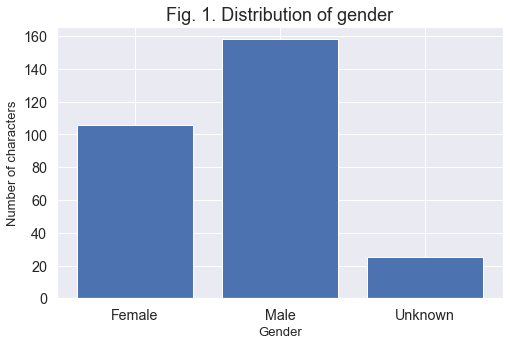

In [6]:
summary = df.groupby("Gender").count()["Name"]
plt.figure(figsize = (8, 5))
fig_count+=1
plt.bar(summary.index, summary.values)
plt.xlabel("Gender", fontsize = 13); plt.ylabel("Number of characters", fontsize = 13);
plt.title("Fig. {}. Distribution of gender".format(fig_count), fontsize = 18);

### Extract dialogues

Another dataset that we will be extensively working with are [dialogues from The Office](https://www.kaggle.com/nasirkhalid24/the-office-us-complete-dialoguetranscript?select=The-Office-Lines-V4.csv). It consists of 54626 lines along with information about which `season`, `episode` and `scene` each line was said in and by whom (`speaker` column). To clean this dataset we focused especially on the latter column: we removed unnecessary colons and corrected misspellings (`cleaner_dialogues` dictionary).

In [7]:
dialogues = pd.read_csv("The-Office-Lines-V4.csv", sep = ';')

# drop rows with empty lines
dialogues.line = dialogues.line.apply(str.strip) # remove any unnecessary spaces in fromt of at the end of speaker name

dialogues.title = dialogues.title.replace("Dwight K. Schrute, (Acting) Manager", "Dwight K. Schrute, Acting Manager")
dialogues.title = dialogues.title.apply(lambda x: x.split(" (")[0]) 

dialogues.speaker = dialogues.speaker.apply(str.strip) # remove any unnecessary spaces in fromt of at the end of speaker name
dialogues.speaker = dialogues.speaker.apply(lambda x: x[:-1] if x[-1] == ":" else x) #fix cases like "Jim:"
dialogues.speaker = dialogues.speaker.apply(lambda x: x[:-2] if x[-2:] == ": " else x) #fix cases like "Jim: "
dialogues.speaker = dialogues.speaker.apply(lambda x: x[1:-1] if ((x[0] == "\"") & (x[-1] == "\"")) else x) #fix cases like " "Jim" "
cleaner_dialogues = {"Dacvid Walalce": "David Wallace", "Dacvid Wallace": "David Wallace", "David Wallcve": "David Wallace",
            "Daryl": "Darryl", "Darrly": "Darryl", "Darry": "Darryl",
            "DeAgnelo": "Deangelo", "DeAngelo": "Deangelo", "Denagelo": "Deangelo",
            "Dight": "Dwight", "Diane": "Diane Kelly", "Donna": "Donna Muraski", "DwightKSchrute": "Dwight",
            "Fred": "Fred Henry", "Gym1 instructor": "Gym Instructor", "Helen": "Helene", "Holy": "Holly",
            "Isabelle": "Isabel", "JIm": "Jim", "Jakey": "Jake", "Jo": "Jo Benett",
            "Julius": "Julius Erving", "Julius Irving": "Julius Erving", "Justin": "Justine","Lonnie": "Lonny",
            "M ichael": "Michael", "MIchael": "Michael", "Mary-Beth": "Merybeth", "Mee-Maw": "MeeMaw", "Meridith": "Meredith",
            "Merv": "Merv Bronte", "Micael": "Michael", "Micahel": "Michael", "Michae": "Michael", "Michael and Samuel together": "Michael and Samuel",
            "Michal": "Michael", "Micheal": "Michael", "Michel": "Michael", "Mihael": "Michael", "Miichael": "Michael",
            "Nellie": "Nellie Bertram", "Pam as \"fourth-biggest client\"": "Pam", "Pam as \"ninth-biggest client\"": "Pam",
            "Pam's Mom": "Pam's mom", "Paul": "Paul Faust", "Pete":"Pete Halpert", "Phil": "Phil Maguire", "Maguire": "Phil Maguire",
            "Phylis": "Phyllis", "Phyliss": "Phyllis", "Stanely": "Stanley", "Teddy": "Teddy Wallace", "Warren": "Warren Buffet", "sAndy": "Andy"}

for key in cleaner_dialogues.keys():
    dialogues.speaker = dialogues.speaker.replace(key, cleaner_dialogues[key])

# Get the number of words each character said
dialogues["number_of_words"] = dialogues.line.apply(str.split).apply(len)

dialogues.head()

,season,episode,title,scene,speaker,line,number_of_words
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,14
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",9
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,14
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",8
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",10


Figure 2. presents the number of lines spoken broken down by a character. Even though **Michael** wasn't present in the 8th season, he still holds the highest number of lines! Apart from that we can see that **Dwight, Jim and Pam** are the most prominent characters in this show. The 5th person in terms of the number of lines spoken is **Andy Bernard**, who replaced Michael Scott and became boss in the 8th season. The rest of the main characters spoke more or less the same number of lines.

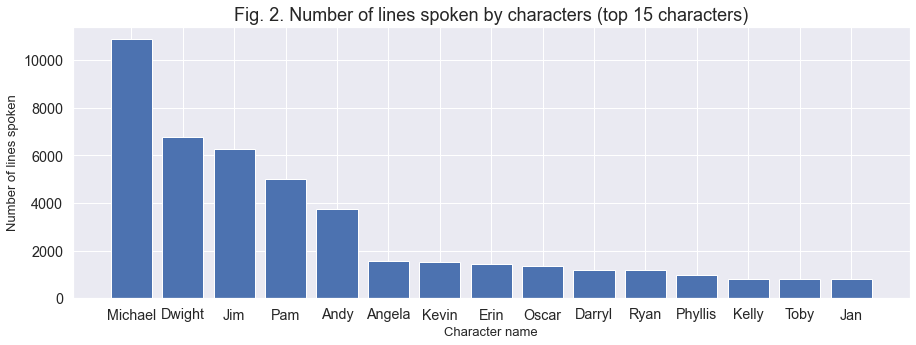

In [8]:
summary = dialogues.groupby("speaker").count()["line"].sort_values(ascending = False)[:15]
plt.figure(figsize = (15, 5))
fig_count+=1
plt.bar(summary.index, summary.values)
plt.xlabel("Character name", fontsize = 13); plt.ylabel("Number of lines spoken", fontsize = 13);
plt.title("Fig. {}. Number of lines spoken by characters (top 15 characters)".format(fig_count), fontsize = 18);

We created a new column - `number_of_words` - which tells us how many words there are in a single line. We can see that **Michael** speaks the longest lines on average. The standard deviation is also the highest for him which might indicate that he had the highest number of monologues, i.e. scenes where he talked to the camera alone.  
**Kevin** speaks the shortest sentences (with the lowest standard deviation as well) which makes sense since this character is not the smartest and lacks communication skills. Kevin received a job as an accountant at Dunder Mifflin after applying for a job in the warehouse because Michael Scott had "a feeling about him."

In [9]:
dialogues.groupby("speaker").agg(["sum", "mean", "std"])["number_of_words"].sort_values(by = "sum", ascending = False)[:10]

,sum,mean,std
speaker,,,
Michael,147523,13.564086,16.268580
Dwight,75134,11.060503,12.463008
Jim,57550,9.193291,10.844793
Pam,44807,8.943513,10.778677
Andy,43746,11.715587,12.687236
Angela,13391,8.628222,9.648312
Erin,12763,8.931421,10.366981
Kevin,12292,7.971466,8.772588
Oscar,11903,8.778024,9.042343


## Create a network

Let's proceed to building a network (directed graph) from our dataframe `df`.

In [10]:
# creating the network
G = nx.DiGraph()
for i in range(df.shape[0]):
    G.add_nodes_from([df.loc[i, "Name_no_underscore"]], gender = df.loc[i, "Gender"], branch = df.loc[i, "Branches"])
    if len(df.loc[i, "Links"]) != 0:
        for j in range(len(df.loc[i, "Links"])):
            G.add_edges_from([(df.loc[i, "Name_no_underscore"], df.loc[i, "Links"][j])])

# remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# extract the largest component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# turn it to undirected graph
G_undirected = G.to_undirected()

# update dataframe - keep only the characters who exist in the largest component
df_gcc = df[df.Name_no_underscore.isin(G.nodes())]
df_gcc = df_gcc.reset_index(drop = True)

After removing isolated nodes and extracting the largest connected component, it consists of **284 nodes and 1241 links**.

In [11]:
print("Number of nodes:", len(G.nodes()))
print("Number of links:", len(G.edges()))
print("Average degree (directed):", np.mean(list(dict(G.degree()).values())))
print("Average degree (undirected):", np.mean(list(dict(G_undirected.degree()).values())))

Number of nodes: 284
Number of links: 1241
Average degree (directed): 8.73943661971831
Average degree (undirected): 6.97887323943662


Top 5 nodes in terms of in-degree are of course the main characters from the show. Top nodes in terms of out-degree are slightly different although they still make sense and are no surprise.

In [12]:
print("Top 5 in-degree nodes:\n", sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:5])
print("Top 5 out-degree nodes:\n", sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:5])

Top 5 in-degree nodes:
 [('Michael Scott', 113), ('Dwight Schrute', 94), ('Jim Halpert', 81), ('Pam Beesly', 77), ('Andy Bernard', 57)]
Top 5 out-degree nodes:
 [('Andy Bernard', 33), ('Michael Scott', 26), ('Phyllis Vance', 26), ('Pam Beesly', 24), ('Dwight Schrute', 24)]


# 3. Tools, theory and analysis

## Analysis of network based on wiki pages

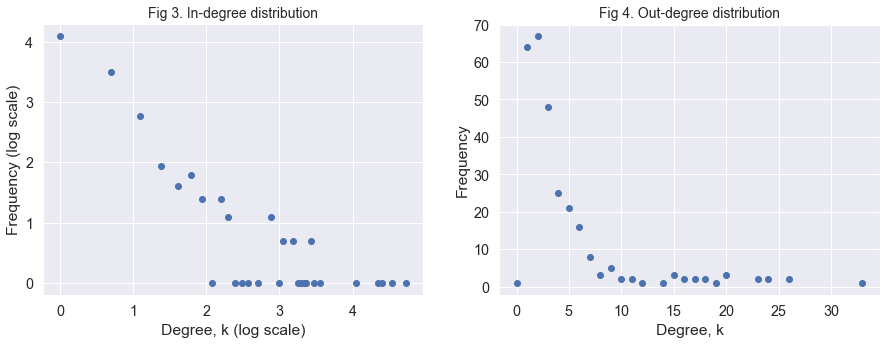

In [13]:
in_d = list(dict(G.in_degree()).values())
out_d = list(dict(G.out_degree()).values())

values_in, counts_in = np.unique(in_d, return_counts = True)
values_out, counts_out = np.unique(out_d, return_counts = True)

from scipy.stats import norm, poisson
rv = poisson(np.mean(out_d))

plt.figure(figsize = (15, 5))
fig_count += 1
plt.subplot(1, 2, 1)
plt.title("Fig {}. In-degree distribution".format(fig_count), fontsize = 14)
plt.xlabel("Degree, k (log scale)")
plt.ylabel("Frequency (log scale)")
plt.scatter(np.log(values_in), np.log(counts_in));
#plt.scatter(values_in, counts_in);
#plt.xscale("log")
#plt.yscale("log")

fig_count += 1
plt.subplot(1, 2, 2)
plt.title("Fig {}. Out-degree distribution".format(fig_count), fontsize = 14)
plt.xlabel("Degree, k")
plt.ylabel("Frequency")
plt.scatter(values_out, counts_out);

Figure 4 (right) shows that the degree distribution of the out-degrees of our network shares similarities to the degree distribution of a **random Erdős–Rényi network**. The in-degree distribution (Fig. 3) is quite different from the Poisson distribution characterizing random networks and seems to follow a **power law**, which is the defining characteristic of a scale-free network.  
The reason for this difference may lay in a way the wiki pages are written, that is, there is no detailed description of who exactly a particular character interacted with in every single scene and this description is mainly limited to the connections to the main characters like MIchale, Dwight, Pam and Jim, who have the highest in-degree (which means that they are mentioned in a lot of character pages).

In [14]:
out_dd = [d for d in out_d if d != 0]
fit = powerlaw.Fit(in_d, discrete=True)
print("γ for in degree:", fit.power_law.alpha)
fit = powerlaw.Fit(out_dd, discrete=True)
print("γ for out degree:", fit.power_law.alpha)
fit = powerlaw.Fit(list(dict(G.degree()).values()), discrete = True)
print("γ for total degree:", fit.power_law.alpha)

γ for in degree: 1.7657920283133341
γ for out degree: 2.29267650830277
γ for total degree: 2.094964250368049


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


The exponent for the in-degree distribution is 1.8, this makes the network of in-links a network in the **Anomalous Regime**.  
The exponent for the out-degree distribution is 2.3, this makes the netwrok of out-links a network in the **Scale-Free Regime**.

Relationship between in- and out-degree:

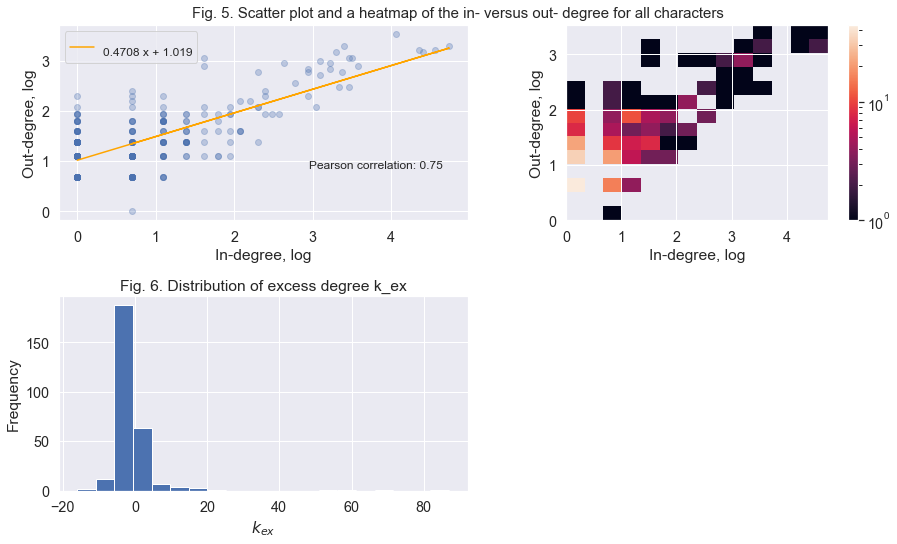

In [15]:
df_degrees = pd.DataFrame([in_d, out_d]).T
df_degrees.columns = ['in_degree', 'out_degree']
df_degrees["excess"] = df_degrees.in_degree - df_degrees.out_degree

from matplotlib.colors import LogNorm
heatmap, xedges, yedges = np.histogram2d(np.log1p(df_degrees.in_degree), np.log1p(df_degrees.out_degree), bins=14)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fit_in = np.poly1d(np.polyfit(np.log1p(df_degrees.in_degree), np.log1p(df_degrees.out_degree), 1))

from scipy.stats import pearsonr
corr, p = pearsonr(np.log1p(df_degrees.in_degree), np.log1p(df_degrees.out_degree))

plt.figure(figsize = (13, 8))

fig_count += 1
plt.subplot(2, 2, 1)
plt.scatter(np.log1p(df_degrees.in_degree), np.log1p(df_degrees.out_degree), alpha = 0.3)
plt.plot(np.log1p(df_degrees.in_degree), fit_in(np.log1p(df_degrees.in_degree)), color = 'orange', label = fit_in)
plt.xlabel("In-degree, log"); plt.ylabel("Out-degree, log")
plt.text(2.95, .85, "Pearson correlation: {}".format(round(corr, 2)), size = 12)
plt.legend(fontsize = 12)

plt.subplot(2, 2, 2)
plt.imshow(heatmap.T, extent=extent, origin='lower', norm = LogNorm())
plt.xlabel("In-degree, log"); plt.ylabel("Out-degree, log")
plt.colorbar()
plt.suptitle(r"Fig. {}. Scatter plot and a heatmap of the in- versus out- degree for all characters".format(fig_count), size = 15, y = .95)
plt.tight_layout()

fig_count += 1
plt.subplot(2, 2, 3)
plt.hist(df_degrees.excess, bins = 20);
plt.xlabel(r"$k_{ex}$"); plt.ylabel("Frequency")
plt.title("Fig. {}. Distribution of excess degree k_ex".format(fig_count));

plt.tight_layout()

Figure 5. shows a clear positive relationship between the in-degree and out-degree values on the log(1+x) scale, which is reflected in a Pearson correlation equal to 0.75. This means that a node with a lot of in-coming links will also have a lot of out-going edges. Additionally, Figure 6. presenting the excess degree defined as $k_{ex} = k_{in} - k_{out}$ [16] shows that for most characters in-degree is usually close to out-degree. We can see some exceptions in a form of a long right tail - these are of course hubs - main characters like Michael, Jim, Dwigt and Pam who have a lot of in-coming links and much fewer out-coming ones.

Let's visualize our first network!

In [16]:
color_map = {
    "Male": "#326DF7",
    "Female": "#F52460",
    "Unknown": "#BABBBE"
}
for i in range(len(df_gcc)):
    G_undirected.nodes[df_gcc.loc[i, "Name_no_underscore"]]['color'] = color_map[df_gcc.loc[i, "Gender"]]

d = dict(nx.degree(G_undirected))

**Run the code block below to see interactive visualisation of network based on wiki pages or see the statis version under this cell.**

In [17]:
import networkx as nx
from pyvis.network import Network
#nx.write_gpickle(G_undirected, "G_undirected.pkl")
main_characters = ["Michael_Scott", "Pam_Beesly", "Jim_Halpert", "Dwight_Schrute", "Meredith_Palmer", "Angela_Martin",
                    "Andy_Bernard", "Creed_Bratton", "Karen_Filippelli", "Kevin_Malone", "Clark_Green", "Kelly_Kapoor",
                    "Oscar_Martinez", "Phyllis_Vance", "Ryan_Howard", "Stanley_Hudson", "Toby_Flenderson", "Darryl_Philbin",
                    "Erin_Hannon", "Gabe_Lewis", "Jan_Levinson", "Nellie_Bertram", "Pete_Miller", "Robert_California", "Roy_Anderson"]
G_undirected = nx.read_gpickle("G_undirected.pkl")
d = dict(nx.degree(G_undirected))
net = Network('600px', '1000px',notebook=True, bgcolor='#222222', font_color='white')

net.from_nx(G_undirected)
for n in net.nodes:
    if d[n["id"]] > 50:
        n["size"] = d[n["id"]]/1.5
    else:
        n["size"] = d[n["id"]]
    if n["id"].replace(" ", "_") not in main_characters:
        n["label"] = ""
        
    n['font']['size'] = 25
        
net.toggle_physics(True)
net.force_atlas_2based(gravity = -80, spring_length = 50)
net.show("wiki_pages_network.html")

![First network](wiki_pages_network.png)

### Centrality measures

Now we will take a closer look at who, among the main characters, is the most central node according to three measures:
* degree centrality,
* betweenness centrality,
* eigenvector centrality.

In [18]:
sorted_dc = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse = True)}
print("5 most central characters according to degree centrality:\n",[(k, round(v, 2)) for k, v in sorted_dc.items()][:5])

sorted_bc = {k: v for k, v in sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse = True)}
print("\n5 most central characters according to betweenness centrality:\n",[(k, round(v, 2)) for k, v in sorted_bc.items()][:5])

sorted_ev = {k: v for k, v in sorted(nx.eigenvector_centrality(G).items(), key=lambda item: item[1], reverse = True)}
print("\n5 most central characters according to eigenvector centrality:\n",[(k, round(v, 2)) for k, v in sorted_ev.items()][:5])

5 most central characters according to degree centrality:
 [('Michael Scott', 0.49), ('Dwight Schrute', 0.42), ('Jim Halpert', 0.37), ('Pam Beesly', 0.36), ('Andy Bernard', 0.32)]

5 most central characters according to betweenness centrality:
 [('Michael Scott', 0.13), ('Dwight Schrute', 0.1), ('Andy Bernard', 0.08), ('Jim Halpert', 0.07), ('Pam Beesly', 0.06)]

5 most central characters according to eigenvector centrality:
 [('Jim Halpert', 0.33), ('Pam Beesly', 0.31), ('Michael Scott', 0.3), ('Dwight Schrute', 0.29), ('Andy Bernard', 0.27)]


It is not surprising that Michael Scott and Dwight Schrute are the most central characters according to degree and betweenness centrality - it is a natural consequence of being nodes with highest degrees. What is interesting is that **Jim Halpert and Pam Beesly are ahead of them in terms of eigenvector centrality**. In contrast to the first two measures, eigenvector centrality goes a step further by also taking into account how well connected a node is, and how many links their connections have. Therefore, these nodes can be more critical as they have an influnce not only on the nodes they are connected to but over **the whole network**.  
So it looks like **Michael Scott and Dwight Schrute have many more connections to unrelevant, side characters** while **neighbors of Jim and Pam are of higher importance to the whole network**.

## Extracting communities

In this section we applied different algorithms for community detection. By partitioning our network into communities we want to uncover hidden structure in the network and discover close relationships between our characters.  

### Louvain algorithm

As a first method, we used **Louvain** algorithm.

Louvain algorithm partions the network into communities by optimizing **modularity** measure. In the context of this measure a partition is good when when there are **many edges within communities and only a few between them** [4] (nodes are densely connected within a community and sparsely connected with the rest of the graph [5]). It is essentially a difference between the number of edges between different communities in a network and the **expected** number of edges if a network was random. The formula is defined in a way that it can only take values between $[-0.5, 1]$ [1]. According to [4], modularity above about 0.3 is a good indicator of significant community structure in a network in practice (network corresponds to a statistically surprising arrangement of edges [6]).

The Louvain algorithm consists of two iteratively repeated steps:  

**Step 1**   
We initialize the algorithm by assigning each node to its own community. Next, for each node $i$:  
* place node $i$ into a community of its neighbour and calculate gain in modularity (using eq. 9.58 from *Network Science* book by Albert-László Barabási);
* repeat this for all neighboring nodes;
* assign node $i$ to a community where the gain in modularity was the highest (if any of the moves can improve the objective function, node $i$ stays in his current community).

Repeat this loop until no further gain in modularity can be achieved., we assign it to a community of his neighbor $j$ and calculate the modularity gain. We reapeat this step for all neighbors of $i$. 

**Step 2**  
Construct a network where nodes are the communities returned in Step 1. Links between nodes of the same community are represented as self-loops. Aggregate each community into a separate node and repeat Step 1 on this aggregated network. 

The two steps are applied iteratively, meaning that the network obtained after each pass is processed again until the modularity cannot be further improved.

We used `python-louvain` package, which is an implementation of the algorithmdescribed above. We set `randomize` argument of a `best_partition` function to `False`, so that the order of node and community evaluation is no longer random but fixed for every call of this function. In turn, the results may be reproducible. We used the undirected version of the GCC of our network.

In [19]:
import community
#partition_louvain = community.best_partition(G_undirected, randomize = True)
# with open('partition_louvain.pkl', 'wb') as f:
#     pickle.dump(partition_louvain, f)

with open('partition_louvain.pkl', 'rb') as f:
    partition_louvain = pickle.load(f)

partition_louvain.pop("David Brent")
# Create a column with a community assignment
df_gcc['Community'] = df_gcc.Name_no_underscore.apply(lambda x: partition_louvain[x])

What is the quality of this partition in terms of modularity score?

Found 9 communities.
Modularity after using Louvain detection method: 0.35972083769057744.


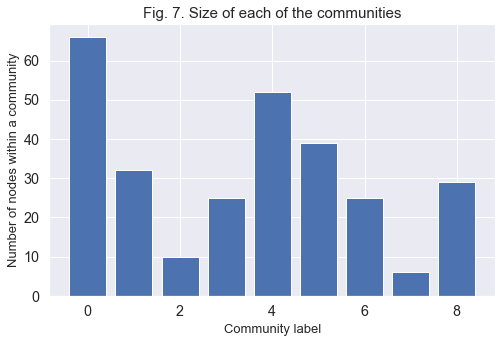

In [20]:
C = len(np.unique(list(partition_louvain.values())))
print("Found {} communities.".format(C))
print("Modularity after using Louvain detection method: {}.".format(community.modularity(partition_louvain, G_undirected)))

values, counts = np.unique(list(partition_louvain.values()), return_counts = True)

fig_count += 1
plt.figure(figsize = (8, 5))
plt.bar(values, counts)
plt.title("Fig. {}. Size of each of the communities".format(fig_count), fontsize = 15)
plt.xlabel("Community label", fontsize = 13); 
plt.ylabel("Number of nodes within a community", fontsize = 13);

The number of communities found is 9 and the corresponding modularity is 0.36. It is positive, which means that the **number of edges within groups exceeds the expected number of edges in a random network** [1]. However, the modularity score is not as high as presented in [2] or [3], which suggests that the communities are not very well defined.  

Can this partition be related to which branch the characters work in? To check this we created a heatmap showing **how many employees of each branch are members of a given community**. Number of employees is scaled by the size of the community. This size is further adjusted by **excluding insignificant characters**. By insignificant characters we mean characters with a **degree lower than or equal to 3**.

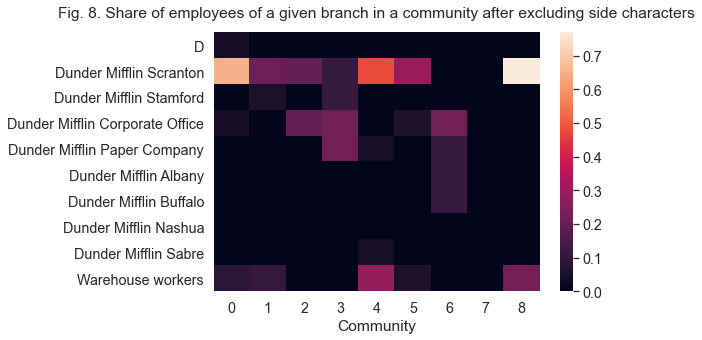

In [21]:
import seaborn as sns
branches = pd.unique(df_gcc.Branches.apply(lambda x: x[0] if len(x) > 0 else "Unknown"))
D = np.zeros((len(branches)+1, C))
D = pd.DataFrame(D)
D.index = np.append(branches, "Warehouse workers")

counts_adjusted = counts.copy()
for k, v in partition_louvain.items():
    if len(G_undirected.nodes[k]['branch']) > 0:
        D.loc[G_undirected.nodes[k]['branch'][0], v] +=1
    else:
        D.loc["Unknown", v] +=1
    if k.replace(" ", "_") in warehouse_workers:
        D.loc["Warehouse workers", v] += 1
    if G_undirected.degree[k] < 4:
        counts_adjusted[v] -= 1

fig_count += 1
plt.figure(figsize = (9, 5))
sns.heatmap(D.drop("Unknown")/counts_adjusted);
plt.title("Fig. {}. Share of employees of a given branch in a community after excluding side characters".format(fig_count), pad = 15);
plt.xlabel("Community");
plt.tight_layout()

Figure 8 shows that most connected characters in community 8 as well as community 4 are mostly Dunder Mifflin Scranton employees and warehouse workers. Besides that, we don't see any other interesting patterns in this partition based on the company branch.  

Therefore, let's take a closer look and visualise the partitioned network.

In [22]:
color_map = {
    0: "#ff0000", # red
    1: "#ffa500", # orange
    2: "#ffff00", # yellow
    3: "#008000", # green
    4: "#0000ff", # blue
    5: "#4b0082", # indigo
    6: "#ee82ee", # violet
    7: "#FFFFFF", # white
    8: "#000000" #black
}
for i in range(len(df_gcc)):
    G_undirected.nodes[df_gcc.loc[i, "Name_no_underscore"]]['color'] = color_map[df_gcc.loc[i, "Community"]]

d = dict(nx.degree(G_undirected))

**Run the code block below to see the interactive partition of our network into communities or head over to https://theofficenetwork.netlify.app/networks/ and take a look at the first vis.**

In [23]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
color_map = {
    0: "#ff0000", # red
    1: "#ffa500", # orange
    2: "#ffff00", # yellow
    3: "#008000", # green
    4: "#0000ff", # blue
    5: "#4b0082", # indigo
    6: "#ee82ee", # violet
    7: "#FFFFFF", # white
    8: "#000000" #black
}

main_characters = ["Michael_Scott", "Pam_Beesly", "Jim_Halpert", "Dwight_Schrute", "Meredith_Palmer", "Angela_Martin",
                    "Andy_Bernard", "Creed_Bratton", "Karen_Filippelli", "Kevin_Malone", "Clark_Green", "Kelly_Kapoor",
                    "Oscar_Martinez", "Phyllis_Vance", "Ryan_Howard", "Stanley_Hudson", "Toby_Flenderson", "Darryl_Philbin",
                    "Erin_Hannon", "Gabe_Lewis", "Jan_Levinson", "Nellie_Bertram", "Pete_Miller", "Robert_California", "Roy_Anderson"]

G_undirected = nx.read_gpickle("G_undirected.pkl")
df_gcc = pd.read_csv("df_gcc.csv")
d = dict(nx.degree(G_undirected))

for i in range(len(df_gcc)):
    G_undirected.nodes[df_gcc.loc[i, "Name_no_underscore"]]['color'] = color_map[df_gcc.loc[i, "Community"]]

net = Network('600px', '1000px',notebook=True, bgcolor='#222222', font_color='white')

net.from_nx(G_undirected)
for n in net.nodes:
    if d[n["id"]] > 50:
        n["size"] = d[n["id"]]/1.5
    else:
        n["size"] = d[n["id"]]
    if n["id"].replace(" ", "_") not in main_characters:
        n["label"] = ""
        
    n['font']['size'] = 25
        
net.force_atlas_2based(gravity = -80, spring_length = 50)
net.show("network2.html")

In addition to the visualisation, below presented are **top 7 most connected characters** (in terms of total node degree in a full network) **in each community**, represented as 3-column block (`Community`, `Name` and `Degree`), which is repeated for every detected community. Direction of reading of the below dataframe is therefore from **left to right**.  
The aim is to see what are the most prominent members in each community, without distracting the reader with side- or guest characters that one might not recognize.

In [24]:
summary = df_gcc.groupby("Community")["Name_no_underscore"].apply(list)
community_summary = pd.DataFrame()
top_n = 7
for i in range(C):# in summary:
    character_degree = sorted([(i, name, G.degree(name)) for name in summary[i]], key= lambda x:x[2], reverse = True)[:top_n]
    character_degree = pd.DataFrame(character_degree, columns = [f"Community {i} (n = {counts[i]})", "Name", "Degree"])
    community_summary = pd.concat([community_summary, character_degree], axis = 1)

community_summary

,Community 0 (n = 66),Name,Degree,Community 1 (n = 32),Name,Degree,Community 2 (n = 10),Name,Degree,Community 3 (n = 25),...,Degree,Community 6 (n = 25),Name,Degree,Community 7 (n = 6),Name,Degree,Community 8 (n = 29),Name,Degree
0,0,Michael Scott,139,1,Jim Halpert,104,2,Kevin Malone,43,3,...,118,6,Jan Levinson,52,7.0,Dawn Tinsley,11.0,8,Phyllis Vance,55
1,0,Toby Flenderson,51,1,Pam Beesly,101,2,Stacy,8,3,...,52,6,Michael Scarn,12,7.0,Tim Canterbury,9.0,8,Stanley Hudson,27
2,0,Meredith Palmer,35,1,Cecelia Halpert,24,2,Brenda Matlowe,6,3,...,49,6,Astrid Levinson,9,7.0,Gareth Keenan,8.0,8,Clark Green,21
3,0,Holly Flax,34,1,Helene Beesly,16,2,Pizza Delivery Kid,6,3,...,24,6,Gil,8,7.0,Lee,6.0,8,Todd Packer,19
4,0,Creed Bratton,27,1,Roy Anderson,16,2,Abby,5,3,...,11,6,Goldenface,7,7.0,Keith Bishop,4.0,8,Bob Vance,18
5,0,Hannah Smoterich-Barr,11,1,Phillip Halpert,15,2,Lynn,2,3,...,11,6,Hunter Raymond,7,7.0,Donna (UK),3.0,8,Cynthia,9
6,0,Louanne Kelley,11,1,Betsy Halpert,13,2,Melissa Riley,2,3,...,9,6,Carol Stills,6,NaN,NaN,NaN,8,Teri Hudson,9


Some of the key insights derived from the above table and visualisation:
* Michael Scott is a member of the largest community (community 0), consisting of 66 people. It is reasonable that [Holly Flax](https://theoffice.fandom.com/wiki/Holly_Flax) (Michael's soulmate) is a member too. To our surprise, he is not connected with any of the main characters besides [Meredith](https://theoffice.fandom.com/wiki/Meredith_Palmer) and [Creed](https://theoffice.fandom.com/wiki/Creed_Bratton), who don't seem to have many friends outside the Scranton Branch and even within it they **did not establish many relationships**. Besides them, the r**est of members have very low degrees**.
* Community 1 seems to be **the best defined** as it is centered around the **relationship betweem Jim and Pam and their families** (we see characters with Beesly and Halpert surnames and [Roy Anderson](https://theoffice.fandom.com/wiki/Roy_Anderson) - former Pam's fiancé).
* Community 2 is a **small community centered around** [Kevin Malone](https://theoffice.fandom.com/wiki/Kevin_Malone) as it includes his sister, daughter, and girlfriends.
* Community 3 consists of employees working in different **Dunder Mifflin branches**, usually occupying (at some point) **managerial positions**, including [David Wallace](https://theoffice.fandom.com/wiki/David_Wallace) - company CFO and later CEO - and his family.

Remaining communities include the rest of main characters in different proportions which is also depenednt on how many different threads along the show they share. For example, in community 4 we have Dwight and Angela who had an affair at the beginning of the show. We also have Oscar who is an accountant just like Angela but he also had an affair with Angela's husband - Robert Lipton!

### Networkx algorithms

However, as mentioned above, the modularity score of Louvain partition is not very high. Therefore, we try other algorithms to see if they are more suitable for this type of network.

Two other algorithms we will test:
* `greedy_modularity_communities` - This function implements **greedy modularity maximization** algorithm described in [4] by Aaron Clauset, M. E. J. Newman and Cristopher Moore. It begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.
* `async_fluidc` - this function implements FLuid Communities algorithm desribed in [5] by Ferran Pares et al. It mimics the behaviour of several fluids (i.e., communities) expanding and pushing one another in a shared, closed and non-homogeneous environment (i.e., a graph), until equilibrium is found.

We will use modularity measure implememented in `community` package to compare quality of different partitions. First, we define a function that **transforms output partition from `networkx` algorithms** (which is a list of sets where each set contains members of a given community) **to a form that is accepted as an input to `community.modularity` function** (which is a dictionary, where keys are node names and values are community label that a node is assigned to). This is done in `transform_partition` function, presented below:

In [25]:
def transform_partition(partition):
    '''
    Transforms partiton returned by networkx algorithms to a form compatible with community.modularity function

    Parameters:
        partition - network partition returned by networkx algorithm to be transformed
    Returns:
        partition_transformed - partition compatible with community.modularity function
    '''
    C = len(partition) # number of communities
    partition_transformed = {}
    # for every community in a networkx partition
    for k in range(C):
        # get node names from a community k
        nodes_k = list(partition[k])
        # for every node
        for node in nodes_k: 
            # assign its community label
            partition_transformed[node] = k

    return partition_transformed

In [26]:
# Run the algorithms
c_greedy_mod_com = list(greedy_modularity_communities(G_undirected))
c_asyn_fluidc = list(asyn_fluidc(G_undirected, 5, 500, 42))

# Transform partition results
c_greedy_mod_com_transformed = transform_partition(c_greedy_mod_com)
c_asyn_fluidc_transformed = transform_partition(c_asyn_fluidc)

# Output modularities
print("Louvain algorithm modularity:", community.modularity(partition_louvain, G_undirected))
print("Greedy algorithm modularity: ", community.modularity(c_greedy_mod_com_transformed, G_undirected))
print("Fluid Communities modularity:", community.modularity(c_asyn_fluidc_transformed, G_undirected))

Louvain algorithm modularity: 0.35972083769057744
Greedy algorithm modularity:  0.36208825952238155
Fluid Communities modularity: 0.22754385839864527


As can be seen from the summary above, we **did not get significantly better results**. We have a slightly higher modularity for a partition returned by a greedy algorithm. However, the difference is at the level of 0.003 which we might by eliminated by rerunning Louvain algorithm as it is a **randomized** method.

One reason behind not so high modularity value might be the bias in the network originated from wiki pages. We need to keep in mind that there is a **tendency of mentioning only the most prominent characters in the description of every other character**. It is understanble that the texts do not include every single encounter or interaction as this is not the purpuse of this website. But we must be aware this fact "skews" the network significantly towards main roles in our tv series.

But is that all we can do to understand the structure of communities in The Office? Of course not :D In the following section we'll make use of our **dialogues dataset** to see if there's something more to be discovered.

### Weighted network based on dialogues

Our dialogues dataset contains every line ever said in The Office. We also know who said it, and in what season, episode and scene. We used this information to create a weighted network. **A link between two characters is placed if they shared at least one scene and weight is the number of scenes shared**.

In [27]:
speakers = pd.unique(dialogues["speaker"])
dialogues_links = dict.fromkeys(speakers, [])

indices = dialogues.groupby(["season", "episode", "scene"]).count()["line"].index
for idx in indices:
    temp = dialogues[(dialogues["season"] == idx[0]) & (dialogues["episode"] == idx[1]) & (dialogues["scene"] == idx[2])]
    speakers = pd.unique(temp["speaker"])
    if len(speakers) > 0:
        for s in speakers:
            links = speakers[speakers!=s]
            dialogues_links[s] = np.append(dialogues_links[s],links)

In [28]:
for node, links in dialogues_links.items():
    weights = nltk.FreqDist(dialogues_links[node])
    dialogues_links[node] = weights

# each node contains a dictionary where keys are links and values are how many scenes a node shared with a link
dialogues_links["Michael"]

FreqDist({'Dwight': 665, 'Pam': 502, 'Jim': 474, 'Kevin': 232, 'Andy': 211, 'Oscar': 207, 'Ryan': 203, 'Phyllis': 194, 'Stanley': 168, 'Angela': 166, ...})

In the above example we can see that Michael shares 665 scenes with Dwight and 502 with Pam, which are the weights of the links between them.

In [29]:
G_dialogues = nx.Graph()

for node, links in dialogues_links.items():
    G_dialogues.add_node(node)
    if len(links) != 0:
        for link, weight in links.items():
            G_dialogues.add_edge(node, link, weight = weight)

# remove isolated nodes
G_dialogues.remove_nodes_from(list(nx.isolates(G_dialogues)))

# extract the largest component
largest_cc = max(nx.connected_components(G_dialogues), key=len)
G_dialogues = G_dialogues.subgraph(largest_cc).copy()

In [30]:
print("Number of nodes:", len(G_dialogues.nodes()))
print("Number of links:", len(G_dialogues.edges()))
print("Average degree:", np.mean(list(dict(G_dialogues.degree()).values())))

Number of nodes: 678
Number of links: 3328
Average degree: 9.817109144542773


Calculating best minimal value for power law fit


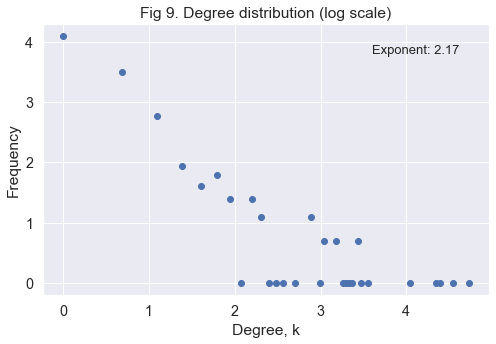

In [31]:
degrees = list(dict(G_dialogues.degree()).values())
fit = powerlaw.Fit(degrees, discrete=True)

values, counts = np.unique(degrees, return_counts = True)

plt.figure(figsize = (8, 5))
fig_count += 1
plt.title("Fig {}. Degree distribution (log scale)".format(fig_count))
plt.xlabel("Degree, k"); plt.ylabel("Frequency");
plt.scatter(np.log(values_in), np.log(counts_in));
plt.text(3.6, 3.8, f"Exponent: {round(fit.power_law.alpha, 2)}", size = 13);

**Run the code block below to see the interactive partition of our network into communities or head over to https://theofficenetwork.netlify.app/networks/ and take a look at the second vis.**

In [32]:
import networkx as nx
from pyvis.network import Network
main_characters = ["Michael_Scott", "Pam_Beesly", "Jim_Halpert", "Dwight_Schrute", "Meredith_Palmer", "Angela_Martin",
                    "Andy_Bernard", "Creed_Bratton", "Karen_Filippelli", "Kevin_Malone", "Clark_Green", "Kelly_Kapoor",
                    "Oscar_Martinez", "Phyllis_Vance", "Ryan_Howard", "Stanley_Hudson", "Toby_Flenderson", "Darryl_Philbin",
                    "Erin_Hannon", "Gabe_Lewis", "Jan_Levinson", "Nellie_Bertram", "Pete_Miller", "Robert_California", "Roy_Anderson"]
G_dialogues = nx.read_gpickle("G_dialogues.pkl")
d2 = dict(nx.degree(G_dialogues))

net2 = Network('500px', '1000px',notebook=True, bgcolor='#222222', font_color='white')
main_characters2 = [name[:name.find("_")] for name in main_characters]
net2.from_nx(G_dialogues)
for n in net2.nodes:
    if d2[n["id"]] > 50:
        n["size"] = d2[n["id"]]/6
    else:
        n["size"] = d2[n["id"]]
    if n["id"] not in main_characters2:
        n["label"] = ""
    n['font']['size'] = 35
        
for e in net2.edges:
    e["value"] = e["weight"]
    e["title"] = f'{e["from"]} - {e["to"]} ({e["weight"]})'
        
net2.force_atlas_2based()
net2.show("network2.html")

In summary, after removing isolated nodes and extracting the largest connected component, new network consists of **678 nodes and 3328 links** between them. Average degree is 9.81. The degree distribution follows powerlaw, which is reflected in Figure 9, and in the value of degree exponent (which is between 2 and 3).  

Let's run the community detection algorithms on this network.

In [33]:
# Run the algorithms
c_louvain = community.best_partition(G_dialogues, weight = "weight")
c_greedy_mod_com_dialogues = list(greedy_modularity_communities(G_dialogues, weight = "weight"))
c_asyn_fluidc_dialogues = list(asyn_fluidc(G_dialogues, 5, 500, 42))

# Transform partition results
c_greedy_mod_com_transformed = transform_partition(c_greedy_mod_com_dialogues)
c_asyn_fluidc_transformed = transform_partition(c_asyn_fluidc_dialogues)

# Output modularities
print("Louvain algorithm modularity:", community.modularity(c_louvain, G_dialogues))
print("Greedy algorithm modularity: ", community.modularity(c_greedy_mod_com_transformed, G_dialogues))
print("Fluid Communities modularity:", community.modularity(c_asyn_fluidc_transformed, G_dialogues))

Louvain algorithm modularity: 0.10743806368433044
Greedy algorithm modularity:  -0.003520155687472156
Fluid Communities modularity: 0.06067001127722397


Unfortunately, the results are even **worse than for the basic network**, created from Wiki pages.  

But we can observe that this network also consists of many nodes with a very low degree - characters that played only in one or two scenes and are mostly connected only to the biggest hubs. What if we could remove these nodes in a specified manner, downgrade the role of hubs and focus our attention only on the most relevant connections? This is what the next section is going to be about.

### Extracting backbone of a weighted network

This section exploits the idea presented in "Extracting the multiscale backbone of complex weighted networks" [7]. We aim at creating a reduced but more meaningful version of our initial weighted network and focus our attention only on the most significant connections to see if the community structure in such a representation will be better defined.  

Therefore, we will remove edges that do not significantly contribute to the total strength of a given node. This strength is defined as the total sum of edge weights leading to a node. Based on that we can normalize the weight $j$ leading to node $i$ using the below formula:

$$
p_{ij} = w_{ij}/s_i,
$$

where $s_i$ is the above mentioned strength of node $i$ and $w_{ij}$ is a weight of edge $j$. Having calculated that we want to then test the hypothesis:

**The normalized weights that correspond to the connections of a certain node of degree k are produced by a random assignment from a uniform distribution.**

We test it by calculating probability $a_{ij}$ of the **normalized weight $p_{ij}$ being compatible with the null hypothesis** (known as famous $p-value$). If $a_{ij}$ is lower than our desired level, we can reject the hypothesis and keep that edge in a network as it **significantly contributes to $i$'s strength**. This way we preserve the edges that satisfy this criterion for **at least one** of the two nodes that it connects.

Thus, **the lower the value of $a$ we choose, the more restrictive** we are towards the edges, consequently leaving only the most relevant ones in our network.

The following code is taken from https://github.com/aekpalakorn/python-backbone-network [8] - python implementation of the above described method.  

First, we create a copy of our original network (graph `B`), calculate the normalized weight for each edge and assign to it its corresponding `alpha_ij` value - the probability of being compatible with the null hypothesis. Next, based on the chosen treshold for `alpha_ij` - `alpha_t` - we decide whether we remove or keep this edge in a `B_cut` graph.

`alpha_t` of our choice is 0.35, which means **we will keep only the edges whose probability of coming from a random assignment is lower than 0.35**.

In [34]:
from scipy import integrate

# Calculate the normalized weight p_ij and the corresponding p-value (alpha_ij)
B = nx.Graph()
for u in G_dialogues:
    k = len(G_dialogues[u])
    if k > 1:
        sum_w = sum(np.absolute(G_dialogues[u][v]["weight"]) for v in G_dialogues[u])
        for v in G_dialogues[u]:
            w = G_dialogues[u][v]["weight"]
            p_ij = float(np.absolute(w))/sum_w
            alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
            B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))

# Perform the cut - remove all links with alpha > alpha_t           
alpha_t = 0.35
B_cut = nx.Graph()#Undirected case:   
for u, v, w in B.edges(data=True):
    try:
        alpha = w['alpha']
    except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
        alpha = 1

    if alpha<alpha_t:
        B_cut.add_edge(u,v, weight=w["weight"])

# remove isolated nodes
B_cut.remove_nodes_from(list(nx.isolates(B_cut)))

# extract the largest component
largest_cc = max(nx.connected_components(B_cut), key=len)
B_cut = B_cut.subgraph(largest_cc).copy()
        
print(f"Number of nodes after cut: {B_cut.number_of_nodes()}. Originally: {G_dialogues.number_of_nodes()}")
print(f"Number of nodes after cut: {B_cut.number_of_edges()}. Originally: {G_dialogues.number_of_edges()}")

Number of nodes after cut: 268. Originally: 678
Number of nodes after cut: 806. Originally: 3328


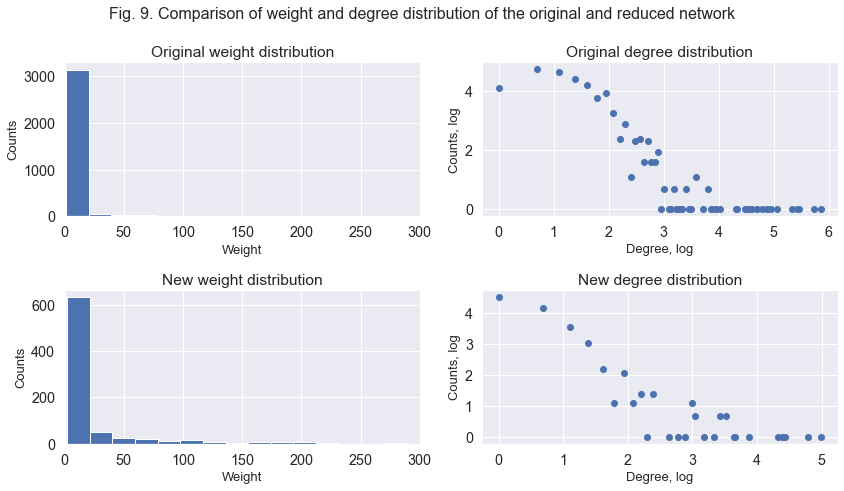

In [35]:
degrees = list(dict(G_dialogues.degree()).values())
values, counts = np.unique(degrees, return_counts = True)

degrees_cut = list(dict(B_cut.degree()).values())
values_cut, counts_cut = np.unique(degrees_cut, return_counts=True)

plt.figure(figsize = (12, 7))
plt.subplot(2, 2, 1)
plt.hist(list(dict(nx.get_edge_attributes(G_dialogues, "weight")).values()), bins = 40);
plt.xlim((0, 300)); plt.xlabel("Weight", fontsize = 13); plt.ylabel("Counts", fontsize = 13)
plt.title("Original weight distribution")
plt.subplot(2, 2, 2)
plt.scatter(np.log(values), np.log(counts));
plt.title("Original degree distribution");plt.xlabel("Degree, log", fontsize = 13); plt.ylabel("Counts, log", fontsize = 13)

plt.subplot(2, 2, 3)
plt.hist(list(dict(nx.get_edge_attributes(B_cut, "weight")).values()), bins = 40);
plt.title("New weight distribution")
plt.xlim((0, 300)); plt.xlabel("Weight", fontsize = 13); plt.ylabel("Counts", fontsize = 13)
plt.subplot(2, 2, 4)
plt.scatter(np.log(values_cut), np.log(counts_cut));
plt.title("New degree distribution"); plt.xlabel("Degree, log", fontsize = 13); plt.ylabel("Counts, log", fontsize = 13)

plt.suptitle("Fig. {}. Comparison of weight and degree distribution of the original and reduced network".format(fig_count), fontsize = 16);
plt.tight_layout()
fig_count+=1

In [36]:
# Run the algorithms
c_louvain = community.best_partition(B_cut, weight = "weight")
c_greedy_mod_com_dialogues = list(greedy_modularity_communities(B_cut, weight = "weight"))
c_asyn_fluidc_dialogues = list(asyn_fluidc(B_cut, 5, 500, 42))

# Transform partition results
c_greedy_mod_com_transformed = transform_partition(c_greedy_mod_com_dialogues)
c_asyn_fluidc_transformed = transform_partition(c_asyn_fluidc_dialogues)

# Output modularities
print("Louvain algorithm modularity:", community.modularity(c_louvain, B_cut))
print("Greedy algorithm modularity: ", community.modularity(c_greedy_mod_com_transformed, B_cut))
print("Fluid Communities modularity:", community.modularity(c_asyn_fluidc_transformed, B_cut))

Louvain algorithm modularity: 0.09592937041536656
Greedy algorithm modularity:  -0.030163286140758618
Fluid Communities modularity: 0.0261803362055951


As can be seen, introducing weighted network based on the dialogues and extracting its backbone did not give any additional information to our community structure.  

Therefore, we can conlude that **most of the plot of The Office indeed focuses on the main characters** and the interactions between themselves or the side characters, but **we do not observe any relations between the side or supporting characters**. This impacts the modularity score, because we have a lot of **"satellite" nodes** - characters that played in single scenes and whose links lead only to hubs or other side characters who by chance played in the same scene (it can be well observed in the visualisation of the full weighted network).

## Analysis of dialogues

In the following section we will put a lot of focus on text analysis, particularly, we will analyse the language that main characters in our show use and try to answer the following questions:

* What are the words that are most typical for each of the characters?
* What do they mostly talk about? Which characters use similar language?
* What is their attitude in general and towards other people?

**TF-IDF** scores will come in handy to answer the first question. Applying **topic modelling** technique to the set of documents representing individual characters will allow us to solve the second question. Lastly, **analysis of sentiment** will help us with the last question.

### Calculating TF-IDF score for main characters

To calculate TF-IDF scores, we first need to preprocess the lines. We followed the below steps to prepare the text:

* Tokenize every line;
* Set everything to lower case;
* Remove stopwords and punctuation;
* Lemmatize the words;
* Filter out character names.

In [37]:
lemmatizer = nltk.WordNetLemmatizer()
tokenizer = WordPunctTokenizer()

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

first_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in first_names])

dialogues["Tokens"] = 0

tokens_full = []
for i in range(len(dialogues)):

    line = dialogues.loc[i, "line"]

    tokens = tokenizer.tokenize(line)

    # Set everything to lower case
    tokens = [t.lower() for t in tokens]
    
    # Remove stopwords and punctuation
    tokens = [w for w in tokens if ((w not in stopwords) & (w.isalnum()))]
    
    # Lemmatize the words
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Filter out character names
    tokens = [token for token in tokens if token not in first_names_lower]

    tokens_full.append(tokens)

dialogues["Tokens"] = pd.Series(tokens_full)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TF-IDF tells us **how relevant a word is for a given document** in a collection of documents. In our case a **single document consists of all the lines a given character said** in a show. Out of nearly 700 distinct speakers in the `dialogues` dataframe, we decided to **use only the ones who said at least 15 lines**. This left us with **104 charatcres** to base our analysis on.

In [38]:
temp = dialogues.groupby("speaker").count()["line"]
sensible_characters = temp[temp > 15].index.tolist()
print("Number of characters with more than 15 lines:", len(sensible_characters))

Number of characters with more than 15 lines: 104


In [39]:
# keep only the lines said by these 104 people
dialogues_new = dialogues[dialogues.speaker.isin(sensible_characters)]

Below we specify the list of characters for whom we will make a detailed analysis. We also define a list of very frequent words but with no informational power that we exclude from our data - `words_to_exclude`. Next, we create `df_characters_full_tokens`, which stores our documents. Lastly, we also try to detect Bigrams to possibly enhance our dataset.

In [40]:
focus_characters = ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl', 'Kelly', 'Jan', 'Toby',
 'Phyllis', 'Stanley']

df_characters_full_tokens = pd.DataFrame(sensible_characters, columns = ['name'])
df_characters_full_tokens['Tokens'] = 0

words_to_exclude = ["oh", "uh", "like", "well", "right", "yeah", "ok", "okay", "know", "think", "hey", "good", "would", "gideon"]

tokens_characters_full = []
for i in range(len(sensible_characters)):
    temp_list = dialogues_new[dialogues_new.speaker == sensible_characters[i]]['Tokens'].values.tolist()
    temp_list = [item for sublist in temp_list for item in sublist if item not in words_to_exclude]
    tokens_characters_full.append(temp_list)

In [41]:
# Detecting bigrams
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Phrases
bigram = Phrases(tokens_characters_full, min_count=10)
for idx in range(len(tokens_characters_full)):
    for token in bigram[tokens_characters_full[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            tokens_characters_full[idx].append(token)

df_characters_full_tokens['Tokens'] = pd.Series(tokens_characters_full)
df_characters_full_tokens.head()

,name,Tokens
0,AJ,"[love, iced, tea, actually, designing, house, ..."
1,Alan,"[great, kinda, stuff, see, dream, see, one, gr..."
2,Alice,"[hi, bci, marketing, consultant, meet, andrew,..."
3,All,"[three, two, one, medium, amount, cheer, happy..."
4,Andy,"[big, tuna, single, pretty, hot, huh, complete..."


Now we're ready to calculate TF-IDF! To do it, we evaluate two metrics:

**Term frequency** score was calculated for each token in each document. We did it by counting how many times each word occurs in each document and normalising this value by the length of a given document.  

**Inverse document frequency** was calculated for each token. First, we identified tokens relevant only for a given character Next, iterating over each unique token, we counted how many documents contain it. Once we had the count $n_t$, we used the following formula to calculate IDF:  
$$
idf(t, D) = log\frac{N}{n_t},
$$
where:
* $t$ is a token,
* $D$ is a set of all documents,
* $N$ is a total number of documents in the corpus,
* $n_t$ is a number of documents $t$ occured in. 
In our calculations $log$ is a natural algorithm, however, as explained by Robertson [9], the base of logarithm does not really matter as the aim of taking the logs is to be able to add them. This may be useful when calculating idf of two tokens: $idf(t_1 \land t_2)$, where $t_1 \land t_2$ is a *term* represented by a boolean *and* operator of *independent* terms $t_1$ and $t_2$. In that case $idf(t_1 \land t_2)$ is simply $idf(t_1) + idf(t_2)$.  
Another benefit of using a sub-linear function such as $log$ is that the effect of very large or very small values (outliers, for example very rare words) is also amortised [10].

Let's start with Term Frequency. As expected, top words in terms of frequency are **common for most of the characters** and are not able to help us differntiate well between them.

In [42]:
'''Calculate TF'''
unique_tokens = set([item for sublist in tokens_characters_full for item in sublist])

# count how many times each token appears in a document (using FreqDIst)
df_characters_full_tokens['Raw_counts'] = df_characters_full_tokens.Tokens.apply(lambda x: sorted(nltk.FreqDist(nltk.Text(x)).items(), key=lambda x: x[1], reverse = True))
# divide the raw count by the number of tokens in a document
df_characters_full_tokens["TF"] = df_characters_full_tokens.apply(lambda x: [(tpl[0], tpl[1]/len(x['Tokens'])) for tpl in x['Raw_counts']], axis = 1)

for i in range(5):
    print("{}: \n\t{}\n".format(focus_characters[i], df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[i]].TF.values[0][:5]))

Michael: 
	[('go', 0.011888370218625113), ('going', 0.011216710884239514), ('get', 0.010259596332740034), ('want', 0.009403230681398395), ('yes', 0.007942371629109716)]

Dwight: 
	[('get', 0.009356444551070594), ('go', 0.008516763629820668), ('one', 0.008216877586517124), ('let', 0.006987344808972591), ('come', 0.006987344808972591)]

Jim: 
	[('really', 0.013448230839535188), ('go', 0.01070635853244549), ('one', 0.009357183270226749), ('get', 0.008965487226356792), ('gonna', 0.008704356530443488)]

Pam: 
	[('really', 0.013843556555993248), ('get', 0.012718064153066966), ('um', 0.010185706246482837), ('one', 0.009904333145751266), ('go', 0.009566685424873381)]

Andy: 
	[('guy', 0.009768451519536902), ('get', 0.00925160223278892), ('go', 0.008269588587967749), ('one', 0.007649369443870168), ('really', 0.007649369443870168)]



Inversed document frequency:

In [43]:
# import pickle#5 as pickle
with open('idf_characters.pkl', 'rb') as f:
    idf = pickle.load(f)

In [44]:
'''Calculate TF_IDF'''
# calculate TF_IDF
df_characters_full_tokens["TF_IDF"] = df_characters_full_tokens.TF.apply(lambda x: [(tpl[0], tpl[1]*idf[tpl[0]]) for tpl in x])
# sort it
df_characters_full_tokens["TF_IDF"] = df_characters_full_tokens["TF_IDF"].apply(lambda x: sorted(x, key= lambda x: x[1], reverse = True))

for i in range(5):
    print("{}: \n\t{}\n".format(focus_characters[i], df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[i]].TF_IDF.values[0][:5]))

Michael: 
	[('going', 0.005271894823792716), ('come', 0.005218115195564439), ('everybody', 0.004899854380076571), ('want', 0.004863882323503332), ('people', 0.004654446566200904)]

Dwight: 
	[('schrute', 0.005537388774239391), ('come', 0.0047101620476907415), ('let', 0.004201767351241217), ('one', 0.0039893582895755425), ('yes', 0.003940150990639492)]

Jim: 
	[('alright', 0.006140748173005176), ('really', 0.0057139272722839), ('wimowheh', 0.005457568624137923), ('wow', 0.00508288069687681), ('let', 0.004632332973900317)]

Pam: 
	[('um', 0.007665463071838214), ('really', 0.005881894525349208), ('mean', 0.004953837475020431), ('one', 0.004808631152367999), ('want', 0.004570020974289034)]

Andy: 
	[('tuna', 0.009583473379386274), ('whoa', 0.004835207481866747), ('guy', 0.004591207666293365), ('bernard', 0.004546966214305085), ('say', 0.003996226422542287)]



And now it looks much more reasonable! To get a better understanding of what the words are for our focus characters, let's **visualise top 15 words in terms of TF-IDF** score!

In [45]:
def green_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(110, 70%%, %d%%)" % random.randint(30, 70)

def red_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 70)
    
def blue_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(214, 80%%, %d%%)" % random.randint(30, 70)

def orange_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(37, 80%%, %d%%)" % random.randint(30, 70)

def pink_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(281, 70%%, %d%%)" % random.randint(30, 70)

color_funcs = [green_color_func, orange_color_func, red_color_func, blue_color_func, pink_color_func]

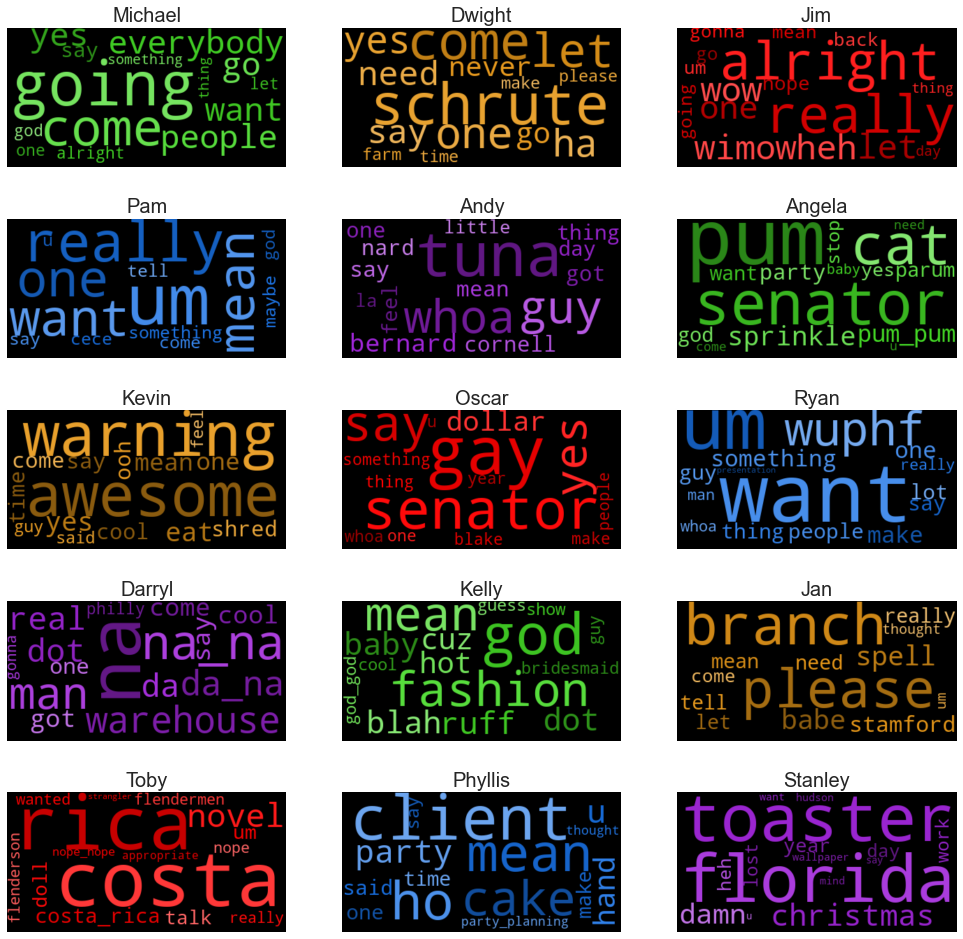

In [46]:
import wordcloud
import random

def green_color_func(word, font_size, position, orientation, font_path=None, random_state=None):
    return "hsl(110, 70%%, %d%%)" % random.randint(30, 70)

plt.figure(figsize = (17, 17))
for i in range(len(focus_characters)):
    character_tokens = df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[i]].TF_IDF.values[0][:15]
    # counts = nltk.FreqDist(nltk.Text(character_tokens))
    text = ''
    for t in character_tokens:
        text = text + ' '.join([t[0]]*round(1000*t[1])) + ' '
    text = text.strip().replace("  ", " ").replace("   ", " ")
        
    plt.subplot(5, 3, int(i+1))
    fig_wordcloud = wordcloud.WordCloud(background_color="black", collocations=False).generate(text)
    plt.imshow(fig_wordcloud.recolor(color_func = color_funcs[i%5]), interpolation="bilinear")  
    plt.axis('off')
    plt.title(focus_characters[i], fontsize=20);

Not this is something! We think that everyone familiar with The Office should be able to distinguish most of the characters by their wordclouds without looking at the titles. We can also see that there are indeed some important bigrams. Let's take a closer look at some of the examples:
* [Here's](https://screenrant.com/office-andy-big-tuna-nickname-jim-why-explained/) an explanation for why Andy was using word "tuna" so often. We also see "cornell" which is his alma mater and this is something he is very proud of.
* [During one of the Christmas parties, Angela sang](https://www.youtube.com/watch?v=Wiwrs8pL1E0) a ["The Little Drummer Boy"](https://www.youtube.com/watch?v=plGj8VRTqJE) song, which is why we see "pum_pum" in her wordcloud :D Additionally, she's a cat lover and one of cats she owned and talked a lot about was named Sprinkle. 
* Darryl is another character who sang songs - https://www.youtube.com/watch?v=i-bZSTLHJm4, https://www.youtube.com/watch?v=bV8i6oCgiAM
* Toby and [Stanley](https://www.youtube.com/watch?v=o0Wjo3bX1n0) really like to talk about their vacations :D
![Toby](Toby.png)

However, we also note that we are aware of the fact that in our case some of the documents and the resulting TF-IDF values were influenced by single episodes, where the supporting characters played more scenes than in an "average" episode that were focused around one theme. This is visible for example for Stanley and word "toaster", which was a theme for only one episode.



### Topic modelling

Now it is time to look at the similarities between the characters. For this purpose we will make use of **Latent Dirichlet Allocation** algorithm. However, we will use it in a somewhat unconventional way. Our aim is not to uncover K different topics that could easily be named as "accounting", "company", "IT", "party". This is not really possible to achieve with The Office dialogues - although there are some main threads that appear throughout many seasons and focus on relationships and operations of Dunder Mifflin Paper Company, **every episode usually tells a completely different story**. This impacts the vocabulary that our characters use in a way that it does not consist of K prevalent topics. In that sense **LDA could do a much better job when used on a collection of documents with a limited number of specifiable topics**.  

Instead, **we will use the identified topics (whatever they might be) to determine which of them are common for which characters**. We will perform some sort of a **clustering** of documents representing our characters. Once we have the topics we can calculate the probability of a document being assigned to a given topic and **this will be the most useful information for our analysis**.

Now a bit of a theory: LDA is an unsupervised method of learning that looks at an unstructured text as a bag of words - that is, order of words does not matter. It assumes that a **topic is a probability distribution over a fixed vocabulary of terms**, that is every word has a probability of belonging to a given topic associated with it. We assume that there exist **$K$ topics in a given collection of documents that exhibit these topics with different proportion**. This assumes that the documents are **heterogeneous**, combining a subset of main ideas or themes that permeate the collection as a whole [11].  

**In our implementation of LDA model, the input vocabulary was reduced by removing unrelevant words according to their TF-IDF value**. This way we pruned out words with no distinctive power, commonly used by most of the characters. This idea is described in [11]. To implement it, we iterate over each document in our `df_characters_full_tokens` dataframe and extract tokens and their corresponding TF-IDF score. Based on the TF-IDF values, for each document **we define a treshold being a 20% quantile of all TF-IDF scores** and store it in `value_tresh`. Every word with a TF-IDF lower than `value_tresh` is removed from a document. 

Filtered vocabulary is stored in `character_tokens_filtered` list.

In [47]:
character_tokens_filtered = []
for i in range(len(df_characters_full_tokens)):
    length = len(df_characters_full_tokens.TF_IDF[i])
    tokens_tfidf = df_characters_full_tokens.TF_IDF[i]#.values
    #treshold = round(length*0.5)
    values = [x[1] for x in tokens_tfidf]
    value_tresh = np.quantile(values, 0.20)
    
    #tokens_tfidf = [x[0] for x in tokens_tfidf][:treshold]
    tokens_tfidf = [x[0] for x in tokens_tfidf if x[1] > value_tresh]
    character_tokens_filtered.append(tokens_tfidf)

Time to build a dictionary - a mapping between words and their integer ids - to build our corpus by mapping the words from `character_tokens_filtered`.

In [48]:
id2word = corpora.Dictionary(character_tokens_filtered)

corpus = []
for page in character_tokens_filtered:
    corpus.append(id2word.doc2bow(page))

And we are ready to train the models. There three hypeparameters that are crucial for model performance:
* `alpha` is a **prior distribution over topic weights in each document** (how much each document "likes" a topic). If we set alpha to **higher values (more than 1), documents will be assigned more topics** and vice versa.
* `eta` is a parameter for the **prior distribution over word weights in each topic** (how much each topic "likes" a word). **Higher values of this parameter will result in a topics made up of more words**. 

As the main theme of every episode is usually very different from one another, we don't want to assign only one topic for a document - this would be an unrealistic assumption. Thus, we decided to det alpha to a rather high value - 0.8. We left `eta` to be symmetric (1 / num_topics) as we don't have any specific assumptions regarding how rich in words a topic should be. We tested the model for 2, 3, 5, 10, 12 and 15 topics.  
As we have 104 documents in our corpus, we told the algorithm to process chunks of size 52 (`chunksize`) and move to M step of EM algorithm after evaluating 2 chunks (`eval_every`).

In [49]:
Nt = [2, 3, 5, 10, 12, 15]
coherences1 = []
coherences2 = []
for n in Nt:
    model = gensim.models.LdaMulticore(id2word = id2word, corpus = corpus, num_topics = n, alpha = 0.8, eta = 'symmetric',
                                  chunksize = 52, eval_every = 2, passes = 10)

    cm1 = CoherenceModel(model=model, corpus=corpus, texts = character_tokens_filtered, coherence='c_v')
    cm2 = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')

    coherences1.append(cm1.get_coherence())  # get coherence value
    coherences2.append(cm2.get_coherence())  # get coherence value

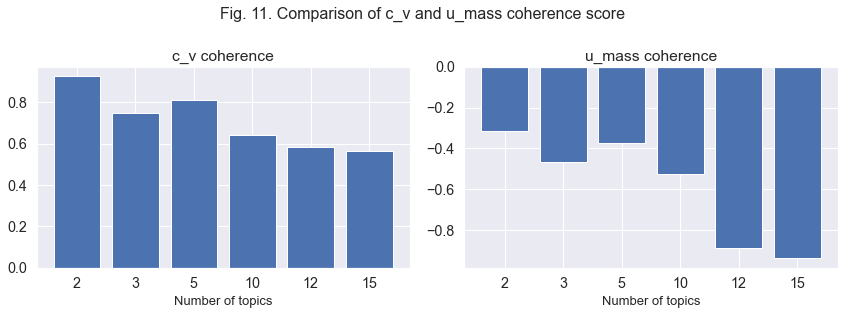

In [50]:
plt.figure(figsize = (12, 4.5))
fig_count += 1
plt.subplot(1, 2, 1)
plt.bar([str(n) for n in Nt], coherences1);
plt.title("c_v coherence"); plt.xlabel("Number of topics", fontsize = 13)
plt.subplot(1, 2, 2)
plt.bar([str(n) for n in Nt], coherences2);
plt.title("u_mass coherence"); plt.xlabel("Number of topics", fontsize = 13);
plt.suptitle("Fig. {}. Comparison of c_v and u_mass coherence score".format(fig_count), fontsize = 16)
plt.tight_layout()

To assess models quality, we calculated coherence scores. The basic idea behind this measure is to **measure the degree of semantic similiarity between highscoring words in the topic** - how coherent the words describing a topic are in comparison with different topics. 

We get the best coherence for lowest number of topics (2 or 3). To proceed with the analysis, we chose 3 topics for the final model.

In [51]:
n_topics = 3
#model = gensim.models.LdaMulticore(id2word = id2word, corpus = corpus, num_topics = n_topics, alpha = 0.8, eta = 'symmetric',
                                  # chunksize = 52, eval_every = 2, passes = 20)
model = gensim.models.LdaMulticore.load('lda_model.lda')
cm1 = CoherenceModel(model=model, corpus=corpus, texts = character_tokens_filtered, coherence='c_v')
cm2 = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')

print(f"C_V COHERENCE: {cm1.get_coherence()}. U_MASS COHERENCE: {cm2.get_coherence()}")
model.show_topics(num_words = 15)

C_V COHERENCE: 0.8244066761427217. U_MASS COHERENCE: -0.3302943425265168


[(0,
  '0.001*"want" + 0.001*"guy" + 0.001*"go" + 0.001*"great" + 0.001*"time" + 0.001*"back" + 0.001*"let" + 0.001*"little" + 0.001*"get" + 0.001*"see" + 0.001*"three" + 0.001*"hear" + 0.001*"gonna" + 0.001*"keep" + 0.001*"yes"'),
 (1,
  '0.001*"got" + 0.001*"get" + 0.001*"let" + 0.001*"want" + 0.001*"really" + 0.001*"one" + 0.001*"work" + 0.001*"call" + 0.001*"go" + 0.001*"come" + 0.001*"say" + 0.001*"give" + 0.001*"night" + 0.001*"gonna" + 0.001*"name"'),
 (2,
  '0.000*"loud" + 0.000*"woman" + 0.000*"see" + 0.000*"eye" + 0.000*"lost" + 0.000*"drive" + 0.000*"tell" + 0.000*"two" + 0.000*"ever" + 0.000*"saw" + 0.000*"hour" + 0.000*"said" + 0.000*"get" + 0.000*"three" + 0.000*"still"')]

As mentioned before, we are not suprised by the fact that these words are not very descriptive. But let's use `pyLDAvis` package to get a better overview of the clusters that LDA created from the words.

In [86]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(model, corpus, id2word)

C:\Users\katin\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043402  0.040391       1        1  40.796946
1     -0.026389 -0.047535       2        1  31.082550
2      0.069790  0.007145       3        1  28.120504, topic_info=         Term       Freq      Total Category  logprob  loglift
4158    magic   8.000000   8.000000  Default  30.0000  30.0000
86      scott  18.000000  18.000000  Default  29.0000  29.0000
8522  suicide   3.000000   3.000000  Default  28.0000  28.0000
6582    bleep   3.000000   3.000000  Default  27.0000  27.0000
1563      got  28.000000  28.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1552    going   3.867628  28.152384   Topic3  -8.1723  -0.7163
3305    thing   3.855490  27.412082   Topic3  -8.1755  -0.6928
2666   really   3.849321  30.339299   Topic3  -8.1771  -0.7959
2357      one   3.842953  27.971918   Topic3  -8.1787  -0.7163
2853      say   3.824195  28.059098   Topic3  -8.1836  -0.7243

[288 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6407       1  0.386120          al
6407       3  0.579179          al
9844       2  0.675115  announcing
374        1  0.479495    anything
374        2  0.399579    anything
...      ...       ...         ...
3648       1  0.532192         yes
3648       2  0.354795         yes
3648       3  0.106438         yes
8874       3  0.693867        yuck
11770      1  0.963034           z

[510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

On the visualisation above the **distance between bubbles shows how similar the topics are and their size represents the importance of each topic over the entire corpus**. Even though the top-scoring words sound very similar, the topics are in fact very different from each other and quite similarly cover the entire corpus - that is there is no one topic that dominates the rest, making them unrelevant.  

Let us know visualise the distribution of topics over the documents for **15 main characters**.

In [53]:
# Collect topic distribution for main characters - a list where each element is a list of length between 1 and 3 (n_topics)
# with the probability
doc_topic_assignment = []
for i in range(len(focus_characters)):
    character_idx = df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[i]].index[0]
    doc_topic_assignment.append(model.get_document_topics(corpus[character_idx]))

# Create a 15x3 matrix to store the probabilities
summary = np.zeros((len(focus_characters), n_topics))
for i in range(len(doc_topic_assignment)):
    #for j in range(len(doc_topic_assignment[i])):
        topics = [x[0] for x in doc_topic_assignment[i]]
        probs = [x[1] for x in doc_topic_assignment[i]]
        summary[i, topics] = probs
        if n_topics != len(topics):
            remaining_probs = (1-np.sum(probs))/(n_topics - len(topics))
            summary[i,summary[i,:] == 0] = remaining_probs

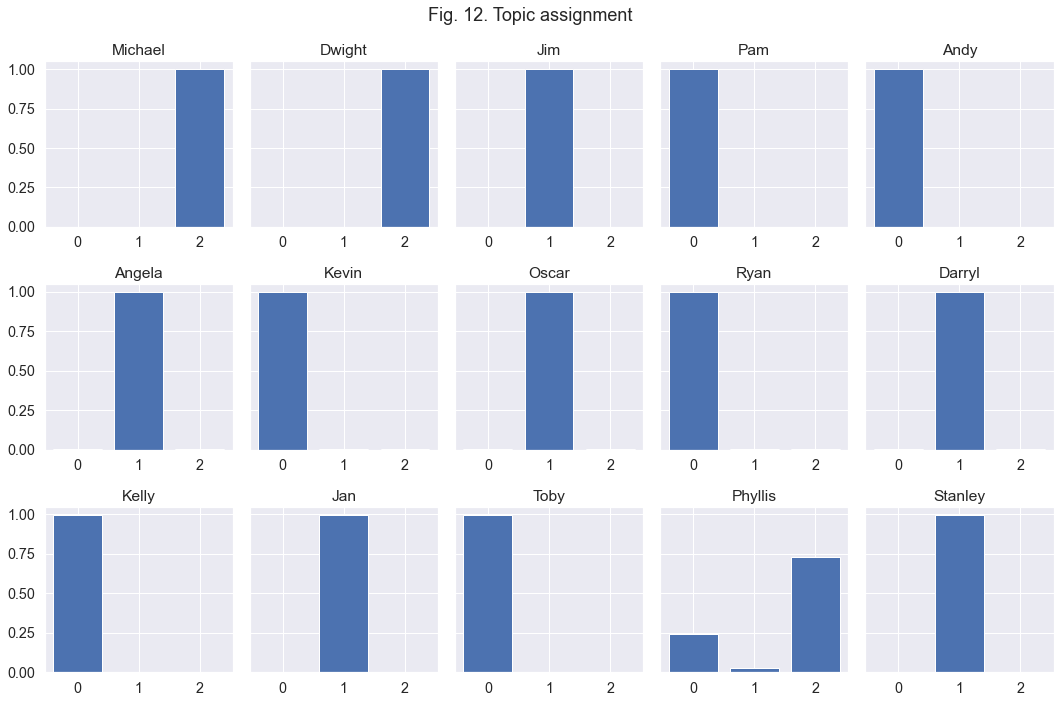

In [54]:
fig, ax = plt.subplots(3, 5, sharey='row',figsize = (15,10))

k = 0
for i in range(3):
    for j in range(5):
        ax[i, j].bar(range(n_topics), summary[k,:])
        ax[i, j].set_title(focus_characters[k])
        ax[i, j].set_xticks(range(n_topics))
        k+=1
fig_count+=1
plt.suptitle("Fig. {}. Topic assignment".format(fig_count), fontsize = 18);
plt.tight_layout()

What is interesting, even after setting `alpha` to a rather high value, almost all of the main characters were clearly assigned only one topic! It is only Phillis whose vocabulary is made up of two different topics.
What we can see from the plot above is that **Angela and Kevin share the same vocabulary - they are both accountants**. And then we also have Stanley in the same cluster, who is indeed similar to Angela in that **they both have rather negative attitudes**, which is reflected in the sentiment analysis.  
Dwight and Michael are also in the same cluster, which might be explained by the fact that both are really interested in holding a managerial position.

#### Hellinger distance

We thought it could also be interesting to actually **measure** what are THE MOST similar characters in terms of the vocabulary they use. For this purpose we will use **Hellinger distance [15]** which was used in [11] to calculate **topic-based similarity measure between documents using posterior topic proportions**. This measure can tell us a difference between two probability distributions $P$ and $Q$. The output is between 0 and 1, where the maximum distance 1 is achieved when $P$ assigns probability zero to every element to which the $Q$ assigns a positive probability, and vice versa [15].  
`gensim` contains implementation of this metric.

In [55]:
from gensim.matutils import hellinger
H = np.zeros((len(focus_characters), len(focus_characters)))
for i in range(len(focus_characters)):
    idx_i = df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[i]].index[0]
    for j in range(len(focus_characters)):
        if i == j:
            H[i, j] = 1
        else:
            idx_j = df_characters_full_tokens[df_characters_full_tokens.name == focus_characters[j]].index[0]
            H[i, j] = hellinger(model[corpus[idx_i]], model[corpus[idx_j]])

In [56]:
def is_topk(a, k = 1):
    _, rix = np.unique(a, return_inverse = True)
    return np.where(rix < k, 1, 0).reshape(a.shape)

H_top_similar = is_topk(H, k = 10)
idx1, idx2 = np.where(H_top_similar == 1)
top_similar_pairs = []
for i in range(len(idx1)):
    top_similar_pairs.append(tuple(sorted((focus_characters[idx1[i]], focus_characters[idx2[i]]))))

In [57]:
H = pd.DataFrame(H)
H.columns = focus_characters
H.index = focus_characters

results = []
for el in set(top_similar_pairs):
    results.append(tuple((el, round(H.loc[el[0], el[1]], 7))))
    
sorted(results, key=lambda x: x[1])

[(('Kevin', 'Ryan'), 1.9e-06),
 (('Angela', 'Oscar'), 2.48e-05),
 (('Dwight', 'Michael'), 3.06e-05),
 (('Darryl', 'Oscar'), 0.0001076),
 (('Jan', 'Stanley'), 0.000128),
 (('Andy', 'Pam'), 0.0001301)]

## Sentiment analysis

#### Character sentiment Season 1-9

In the first part of this analysis, we investigate the **sentiment of character dialogue from the entire TV series**, ie. all 9 seasons combined. A temporal analysis is given in the following section, where the dialogue from each season is handled separately.

To calculate the sentiments of dialogues using LabMT word list (dictionary-based approach) [12], we first preprocessed the dialogues and filtered out the tokens that are not available in the **LabMT** list. To calculate sentiments using **VADER** word list (the rule-based approach) [13], we did not do any preprocessing (except for removing symbols that are not alfanumeric from the sentences) but input sentence by sentence to calculate the average compound polarity. The reason we did not apply any preprocessing is that we wanted to preserve the punctuation and capitalization of words as well as their order. Additionally, as shown in the section of code examples in the vaderSentiment documentation page, raw sentences were used as an input to SentimentIntensityAnalyzer object.

In order to better visualize and compare results, we will limit part of our analysis to the the 15 main characters (as defined by us in the `speakers` list).

In [58]:
main_characters = ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith']
speakers = main_characters.copy()
print("Main characters are:")
print(*speakers, sep = ", ")

Main characters are:
Michael, Dwight, Jim, Pam, Andy, Angela, Kevin, Oscar, Ryan, Darryl, Jan, Toby, Phyllis, Stanley, Meredith


First, we import a dataframe of preprocessed tokens, which was already produced in the previous section TF-IDF (stopwords and punctuation removed, lemmatized, filtered out character names, and "rescued" words with an apostrophe such as can't and won't.)

In [59]:
dialogues = pd.read_csv("The_Office_Dialogues_processed_tokens.csv",index_col=0)
dialogues = dialogues.dropna(subset=["Tokens"]) # drop rows with empty lists of tokens
dialogues = dialogues.dropna(subset=["line"]) # drop rows with empty lines of dialogue
# drop rows where speaker contains '/'
dialogues = dialogues.drop(dialogues[dialogues.speaker.str.contains('/')].index)
dialogues.head()

,season,episode,title,scene,speaker,line,number_of_words,Tokens
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,14,"['right', 'quarterly', 'look', 'good', 'thing']"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",9,"['oh', 'told']"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,14,"['come', 'master', 'guidance', 'saying']"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",8,"['actually', 'called']"
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",10,"['right', 'well', 'let', 'show']"


Next, we create new dataframe `df_speakers_full_tokens` with columns `Speaker` (one row  per each unique speaker) and `Tokens` (a list of all processed tokens). 

In [60]:
# convert the literal tuples into Python tuple objects
dialogues['Tokens'] = dialogues.Tokens.apply(lambda x: ast.literal_eval(str(x)))

speakers_all = np.unique(dialogues.speaker) # Includes all unique speakers in the dialogues dataframe
df_speakers_full_tokens = pd.DataFrame(speakers_all, columns = ['Speaker'])
df_speakers_full_tokens['Tokens'] = 0

tokens_speakers_full = []
for i in range(len(speakers_all)):
    temp_list = dialogues[dialogues.speaker == speakers_all[i]]['Tokens'].values.tolist()
    temp_list = [(item) for sublist in temp_list for item in sublist]
    tokens_speakers_full.append(temp_list)

df_speakers_full_tokens['Tokens'] = pd.Series(tokens_speakers_full)

# Drop rows with an empty list of tokens and reset index
df_speakers_full_tokens = df_speakers_full_tokens.drop(df_speakers_full_tokens[df_speakers_full_tokens["Tokens"].str.len() == 0].index)
df_speakers_full_tokens = df_speakers_full_tokens.reset_index(drop=True)
df_speakers_full_tokens.head()

,Speaker,Tokens
0,3rd Athlead Employee,"[work, home, shopping]"
1,4th Athlead Employee,"[laywer, one, honestly]"
2,A.J.,"[raised, yeah, pretty, serious, feel]"
3,AJ,"[love, iced, tea, designing, like, put, pair, ..."
4,Aaron Rodgers,"[middle, aged, lot, flag, look, terrible, hear..."


To perform the dictionary-based sentiment analysis, we filter out tokens that are not in the labMT list and save filtered tokens in the `Tokens_labMT` column.

In [61]:
# Download the LabMT and VADER wordlists
labMT = pd.read_csv("Data_Set_S1.txt", sep = '\t')
vader = pd.read_csv("https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt", sep = '\t', header = None)
vader.columns = ["word", "mean", "std", "raw_rating"]
labMT_words = labMT.word.values

In [62]:
speakers_all = df_speakers_full_tokens.Speaker.tolist() # Includes all unique speakers in the dialogues dataframe
dialogue_tokens_full = []
dialogue_tokens_labMT = []
df_speakers_full_tokens['Tokens_labMT'] = 0

for i in range(len(speakers_all)):
    new_tokens = df_speakers_full_tokens[df_speakers_full_tokens.Speaker == speakers_all[i]]['Tokens'].values.tolist()[0]
    # Filter out the tokens that are not available on the labMT list
    tokens_labMT = [t for t in new_tokens if t in labMT_words]
    # Append filtered tokens to list
    dialogue_tokens_labMT.append(tokens_labMT)

df_speakers_full_tokens['Tokens_labMT'] = pd.Series(dialogue_tokens_labMT)

# Drop rows with an empty list of tokens and reset index
df_speakers_full_tokens = df_speakers_full_tokens.drop(df_speakers_full_tokens[df_speakers_full_tokens["Tokens_labMT"].str.len() == 0].index)
df_speakers_full_tokens = df_speakers_full_tokens.reset_index(drop=True)
df_speakers_full_tokens.head()

,Speaker,Tokens,Tokens_labMT
0,3rd Athlead Employee,"[work, home, shopping]","[work, home, shopping]"
1,4th Athlead Employee,"[laywer, one, honestly]","[one, honestly]"
2,A.J.,"[raised, yeah, pretty, serious, feel]","[raised, yeah, pretty, serious, feel]"
3,AJ,"[love, iced, tea, designing, like, put, pair, ...","[love, tea, like, put, pair, size, really, lov..."
4,Aaron Rodgers,"[middle, aged, lot, flag, look, terrible, hear...","[middle, aged, lot, flag, look, terrible, hear..."



Below, we calculate and plot the LabMT and VADER sentiment

In [63]:
speakers_all = df_speakers_full_tokens.Speaker.tolist()

df_speakers_full_tokens["Sentiment_labMT"] = 0
df_speakers_full_tokens["Sentiment_vader"] = 0

analyzer = SentimentIntensityAnalyzer()

for i in range(len(speakers_all)):

    # Calculate labMT sentiment
    tokens_labMT = df_speakers_full_tokens[df_speakers_full_tokens.Speaker == speakers_all[i]].Tokens_labMT.values.tolist()[0][:]
    
    n_words = len(tokens_labMT) # Count number of processed tokens for the speaker
    fdist = nltk.FreqDist(tokens_labMT) # Calculate frequence of each token (dictionary with keys: token, value: frequency)
    sentiment_labMT = 0    
    for t in list(fdist.keys()):
        sentiment_labMT += fdist[t]*labMT[labMT.word == t]['happiness_average'].values[0] # Compute sentiment sum
    df_speakers_full_tokens.loc[i, "Sentiment_labMT"] = sentiment_labMT/n_words # Compute average sentiment and append to df
    
    # Calculate VADER sentiment
    sentences = dialogues[dialogues.speaker == speakers_all[i]]["line"].values
    vs = []
    for sentence in sentences:
        vs.append(analyzer.polarity_scores(sentence)["compound"])
    df_speakers_full_tokens.loc[i, "Sentiment_vader"] = np.mean(vs)


As seen in the below figures, the **majority of the characters' dialogue have positive sentiment** as compared to the neutral, which is 5.0 and 0.0 for LabMT and VADER, respectively. Furthermore, the distribution of sentiment scores has the shape of a normal distribution for both dictionaries. 

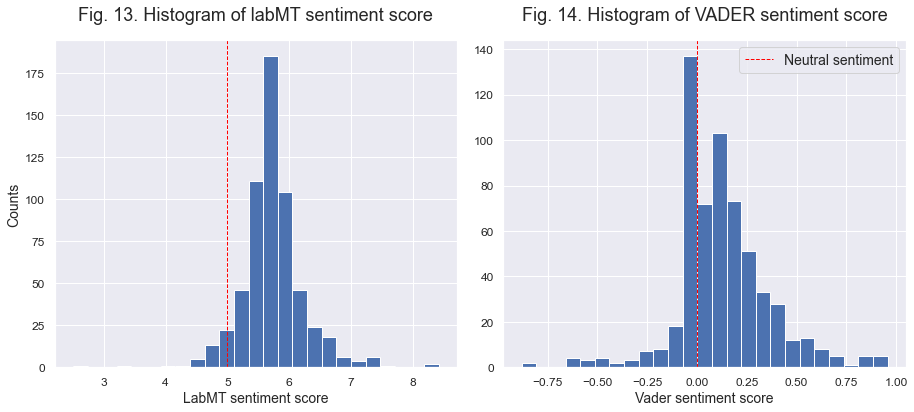

In [64]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))

fig_count+=1
axs[0].hist(df_speakers_full_tokens.Sentiment_labMT, 25);
axs[0].axvline(x = 5, linestyle = '--', linewidth = 1, color = 'red', label = "Neutral sentiment")
axs[0].set_title("Fig. {}. Histogram of labMT sentiment score".format(fig_count), fontsize = 18, pad = 20);
axs[0].set_xlabel("LabMT sentiment score", fontsize = 14)
axs[0].set_ylabel("Counts", fontsize = 14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

fig_count+=1
axs[1].hist(df_speakers_full_tokens.Sentiment_vader, 25);
axs[1].axvline(x = 0, linestyle = '--', linewidth = 1, color = 'red', label = "Neutral sentiment")
axs[1].set_title("Fig. {}. Histogram of VADER sentiment score".format(fig_count), fontsize = 18, pad = 20);
axs[1].set_xlabel("Vader sentiment score", fontsize = 14); #plt.ylabel("Counts", fontsize = 14)
axs[1].legend(fontsize = 14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

In order to better visualize and compare results, we will limit our scope to only the **15 main characters** (as defined by us). Their sentiments are ranked below using the two different approaches.

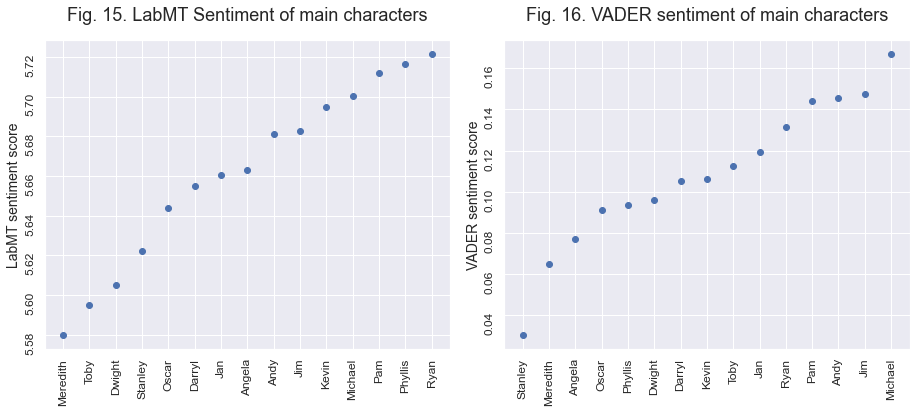

In [65]:
df_speakers_full_tokens_main_characters = df_speakers_full_tokens[df_speakers_full_tokens['Speaker'].isin(main_characters)]

fig, axs = plt.subplots(1, 2, figsize = (13,6))

# sort freq
df_speakers_full_tokens_main_characters.sort_values("Sentiment_labMT", ascending=True, inplace=True)

fig_count+=1
axs[0].scatter(df_speakers_full_tokens_main_characters.Speaker, np.array(df_speakers_full_tokens_main_characters["Sentiment_labMT"]))
axs[0].set_title("Fig. {}. LabMT Sentiment of main characters".format(fig_count), fontsize = 18, pad = 20)
axs[0].set_ylabel("LabMT sentiment score", fontsize = 14)
axs[0].tick_params(labelrotation=90)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# sort freq
df_speakers_full_tokens_main_characters.sort_values("Sentiment_vader", ascending=True, inplace=True)

fig_count+=1
axs[1].scatter(df_speakers_full_tokens_main_characters.Speaker, np.array(df_speakers_full_tokens_main_characters["Sentiment_vader"]))
axs[1].set_title("Fig. {}. VADER sentiment of main characters".format(fig_count), fontsize = 18, pad = 20)
axs[1].set_ylabel("VADER sentiment score", fontsize = 14)
axs[1].tick_params(labelrotation=90)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

The **most positive character** across all season using the **dictionary-based approach** is Ryan and the **most negative** is Meredith. Pam, Michael and Jim are all in the top six, which we expect based on our prior knowledge about the show. However, among characters with negative sentiment we would expect to see Angela and Stanley, which hints to the LabMT method being inaccurate. The sentiment analysis following the **rule-based approach** leads to a ranking of characters that is better in line with our expectations. Stanley, Meredith and Angela often complain and express themselves negatively around the office, whereas Michael and Jim are extremely energetic and positive, which is clearly expressed in their language. 

In fact, LabMt doesn't work well with our dataset, since we have very short sentences after removing stop words and hereby lose part of the context of the conversation. The rule-based VADER method tries to take the context of a sentence into account, i.e. the overall sentiment of a sentence/document might be intensified or decreased based on how one word is used in combination with others. Hence, the **rule-based approach is a stronger tool** and we will only apply the VADER sentiment in the following sections.

#### Temporal analysis: Character sentiment per season

In this section we will perform **sentiment analysis on the seperate seasons** of The Office to provide a temporal dimension. Provided the results above, we will only use VADER based sentiment, since the dictionary (LabMT) method gave inaccurate results and is computationally less efficient.

In [66]:
# There are 9 seasons of the show, which we will iterate through below
seasons = np.unique(dialogues.season)

# Define speakers and create new dataframe for the tokens per season
main_characters = ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith']
df_speakers_sentiment = pd.DataFrame(main_characters, columns = ['Speaker'])

In [67]:
# Looking only at the main characters
speakers = main_characters.copy()
analyzer = SentimentIntensityAnalyzer()

for i in range(len(seasons)): # iterate through seasons
    dialogues_season = dialogues[dialogues.season == i+1] # dialogue in season i

    # Compute VADER sentiment scores   
    df_speakers_sentiment['Sentiment season {}'.format(i+1)] = 0
    
    for j in range(len(speakers)):
        # Calculate VADER sentiment
        sentences = dialogues_season[dialogues_season.speaker == speakers[j]]["line"].values
        vs = []
        for sentence in sentences:
            vs.append(analyzer.polarity_scores(sentence)["compound"])
        df_speakers_sentiment.loc[j, 'Sentiment season {}'.format(i+1)] = np.mean(vs)


`df_speakers_sentiment` includes the main characters' sentiment scores for every season 

In [68]:
df_speakers_sentiment

,Speaker,Sentiment season 1,Sentiment season 2,Sentiment season 3,Sentiment season 4,Sentiment season 5,Sentiment season 6,Sentiment season 7,Sentiment season 8,Sentiment season 9
0,Michael,0.198324,0.175001,0.170186,0.186209,0.163672,0.144045,0.157944,NaN,0.271150
1,Dwight,0.102117,0.105901,0.083596,0.072723,0.060812,0.085127,0.103273,0.098294,0.142454
2,Jim,0.185392,0.182891,0.137028,0.138211,0.122581,0.141750,0.126716,0.152580,0.164847
3,Pam,0.110567,0.123833,0.151794,0.140262,0.133258,0.125376,0.147635,0.156432,0.182110
4,Andy,NaN,NaN,0.159464,0.181827,0.123225,0.136722,0.146307,0.157663,0.133504
5,Angela,0.008643,0.111666,0.095349,0.029166,0.055130,0.055360,0.095314,0.082299,0.089698
6,Kevin,0.002548,0.038903,0.098188,0.091667,0.087123,0.132165,0.120623,0.095666,0.141817
7,Oscar,0.194307,0.060671,0.094134,0.100811,0.092450,0.054115,0.107670,0.096253,0.087991
8,Ryan,0.179127,0.088323,0.100761,0.143640,0.141931,0.095698,0.189789,0.135929,0.084575
9,Darryl,-0.045647,0.066237,0.098886,0.082636,0.059926,0.066323,0.106140,0.108359,0.149716


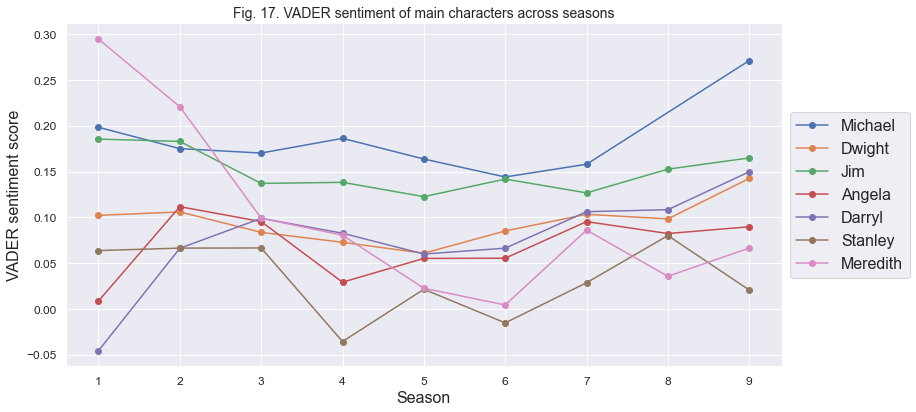

In [69]:
plt.figure(figsize = (13,6))
fig_count+=1
for i in [0, 1, 2, 5, 9, 13, 14]:#range(len(main_characters)):
    sentiment_score = df_speakers_sentiment.iloc[i].tolist()[1:10]
    sentiment_score = np.array(sentiment_score)
    smask = np.isfinite(sentiment_score)
    plt.plot(seasons[smask], sentiment_score[smask], label = "{}".format(main_characters[i]), linestyle='-', marker='o')
plt.title("Fig. {}. VADER sentiment of main characters across seasons".format(fig_count), fontsize = 14)
plt.ylabel("VADER sentiment score", fontsize = 16)
plt.xlabel("Season", fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize = 16, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

**In the comparison above**, Meredith's sentiment generally drops, while Darryl becomes more and more postive for every season. Again, Stanley and Angela are constantly having low scores. Dwight also has a very monotonuous mood across seasons, however, he expresses himself more positively than the two aforementioned characters. Jim is generally quite happy, but Michael tops the list when it comes to high sentiment scores, and this is despite a slight drop in Season 6. 

The plots below give an even better understanding of how main character's sentiment has developed across the different seasons. There is a point for every season the character appeared in the show.

In [70]:
main_characters = ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith']

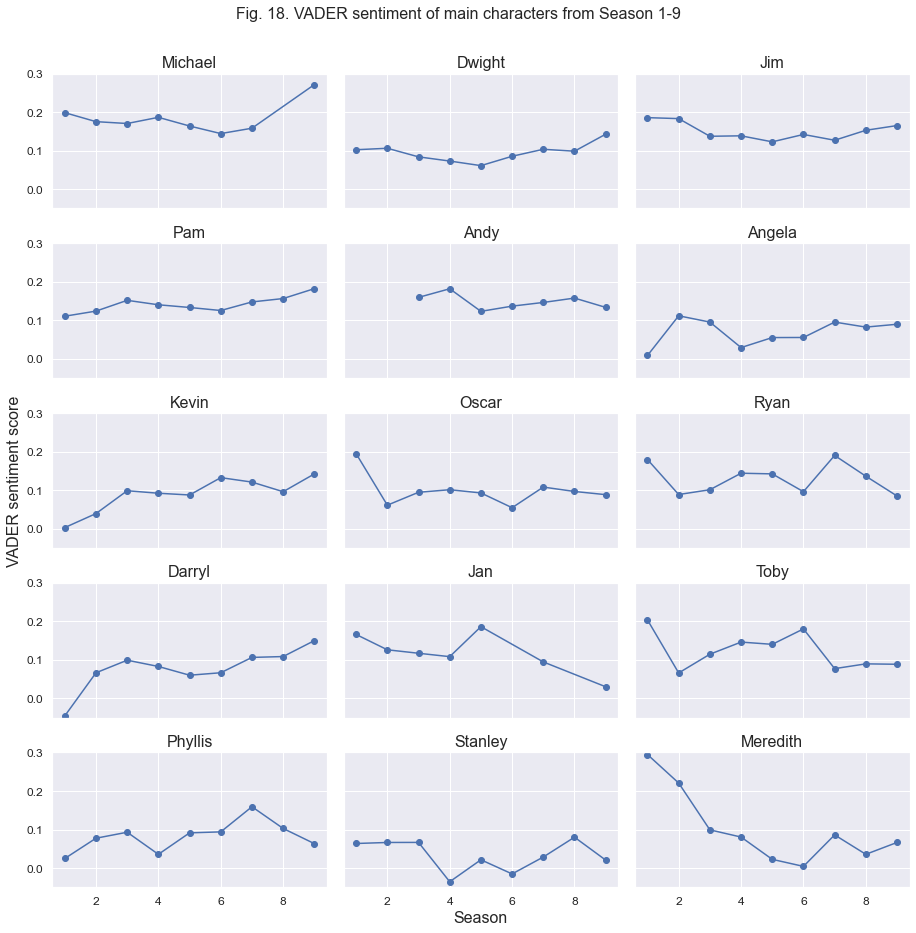

In [71]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, sharex='col', sharey='row',figsize = (13,13))
fig_count+=1
for i in range(len(main_characters)):
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]
    sentiment_score = df_speakers_sentiment.iloc[i].tolist()[1:10]
    sentiment_score = np.array(sentiment_score)
    smask = np.isfinite(sentiment_score)
    ax[i].plot(seasons[smask], sentiment_score[smask], label = "{}".format(main_characters[i]), linestyle='-', marker='o')
    ax[i].set_title("{}".format(main_characters[i]), fontsize = 16)
    ax[i].set_ylim(-0.05, 0.3)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].grid(True)
    
# Set common labels
ax14.set_xlabel("Season", fontsize = 16)
ax7.set_ylabel("VADER sentiment score", fontsize = 16)

plt.suptitle("Fig. {}. VADER sentiment of main characters from Season 1-9".format(fig_count), fontsize = 16, y=1.0)
plt.tight_layout()

The figure above illustrates the change in sentiment for the main characters across.

#### Sentiment two people conversations

This sections tries to answer the question: How are the characters' **attitudes towards each other**? Thus, we have isolated the **scenes where only two characters appear** and analysed the words they speak to each other. We thereby make two key assumptions about the two characters in the scene:<br> 
1) Their speech is directed to one another <br>
2) The **sentiment** of one person's dialogue represents their **attitude** to the other person<br>



In [72]:
# We need an alphabetically sorted list of main characters
main_characters = sorted(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith'])

We find the scenes where only characters appear.

In [73]:
a = dialogues[["scene", "speaker"]].groupby("scene").nunique() # Find number of speakers in each scene
a = a[a.speaker == 2].index.tolist() # Find scenes with only 2 speakers
temp = dialogues[dialogues.scene.isin(a)] # temp is a dataframe of 2 people scenes 
temp = temp.groupby('scene')['speaker'].apply(lambda x: list(np.unique(x)))
temp = temp.apply(lambda x: "{}-{}".format(x[0], x[1]))
temp

scene
1               Jim-Michael
3               Michael-Pam
12          Phyllis-Stanley
14             Angela-Kevin
15                  Jim-Pam
               ...         
8120        Phyllis-Stanley
8122             Kelly-Ryan
8130    David Wallace-Oscar
8133                Jim-Pam
8149            Kevin-Oscar
Name: speaker, Length: 2680, dtype: object

We proceed by calculating the sentiment of dialogue in every 2-person scene and saving the result to a dataframe.

In [74]:
df_speakers_full_tokens = pd.DataFrame()
analyzer = SentimentIntensityAnalyzer()

for j in range(len(main_characters)):
    for i in range(len(main_characters)):
        # Character pairs in the temp object is alphabetically ordered
        # The code below ensures that we keep the order
        if (i < j):
            temp2 = temp[temp=="{}-{}".format(main_characters[i],main_characters[j])]
        elif (i > j):
            temp2 = temp[temp=="{}-{}".format(main_characters[j],main_characters[i])]
        else:
            temp2 = temp[temp=="{}-{}".format(main_characters[j],main_characters[j])]
        index_list = temp2.index.tolist()

        dialogue_2_people = dialogues[dialogues.scene.isin(index_list)]

        if j == 0:
            df_speakers_full_tokens["{}".format(main_characters[i])] = 0

        # Calculate VADER sentiment
        sentences = dialogue_2_people[dialogue_2_people.speaker == main_characters[i]]["line"].values
        vs = []
        for sentence in sentences:
            vs.append(analyzer.polarity_scores(sentence)["compound"])
        df_speakers_full_tokens.loc[j, "{}".format(main_characters[i])] = np.mean(vs)

In [75]:
df_speakers_full_tokens = df_speakers_full_tokens.set_axis(main_characters)
df_speakers_full_tokens

,Andy,Angela,Darryl,Dwight,Jan,Jim,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
Andy,NaN,0.079055,0.073047,0.117011,NaN,0.127944,0.165305,0.018300,0.205345,0.151505,0.029646,0.196131,0.546350,0.011225,0.046171
Angela,0.272836,NaN,NaN,0.126923,NaN,0.196463,0.115853,NaN,0.291900,0.092607,0.156489,0.133554,0.000000,-0.387500,0.000000
Darryl,0.133747,NaN,NaN,0.149700,NaN,0.159736,0.263350,NaN,0.160078,0.149746,0.283212,0.180600,NaN,NaN,0.200950
Dwight,0.138567,0.028204,0.178684,NaN,0.057342,0.087197,0.054991,0.058840,0.125499,0.013369,0.126901,0.031289,0.121748,0.102608,0.170838
Jan,NaN,NaN,NaN,0.151777,NaN,0.306209,NaN,NaN,0.130436,0.000000,0.104573,NaN,NaN,NaN,NaN
Jim,0.182300,0.050237,0.138964,0.063995,0.261433,NaN,0.155039,-0.007190,0.121422,0.529880,0.139589,0.099545,0.205947,0.219460,0.096931
Kevin,0.138858,0.064081,-0.048800,-0.112477,NaN,0.208570,NaN,0.051033,0.165321,0.084827,0.198912,NaN,0.005200,NaN,0.098780
Meredith,0.087450,NaN,NaN,0.086500,NaN,0.316380,-0.259433,NaN,0.173577,NaN,0.005614,0.041700,0.000000,NaN,NaN
Michael,0.050869,0.173844,0.083758,0.071412,0.118610,0.151507,0.083103,0.129822,NaN,0.097100,0.107454,0.144766,0.096567,0.043586,0.138167
Oscar,0.243782,0.124272,0.171023,0.126326,0.250000,0.091000,0.112268,NaN,0.172038,NaN,0.139957,0.499050,0.029400,NaN,-0.049190


The **heatmap** below illustrates the results. Speakers (1<sup>st</sup> character in the scene) are plotted along the x-axis, and Receivers (2<sup>nd</sup> person in the scene) are plotted along the y-axis. As an example, Dwight has a negative attitude towards Kevin (sentiment score = -0.11) whereas Kevin's attitude towards Dwight is positive (score = 0.06). Some pairs of characters never shared a scene together resulting in a blank square in the heatmap.

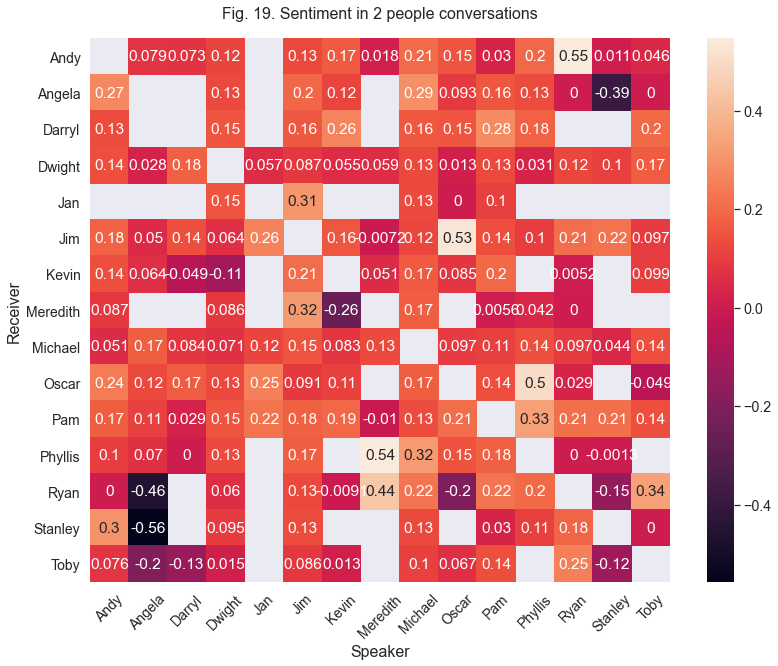

In [76]:
plt.figure(figsize = (13, 10))
fig_count+=1
sns.heatmap(df_speakers_full_tokens, annot=True)
plt.xticks(rotation = 45, fontsize = 14);plt.yticks(rotation = 0, fontsize = 14);
plt.title("Fig. {}. Sentiment in 2 people conversations".format(fig_count), fontsize = 16, pad = 20);
plt.ylabel("Receiver", fontsize = 16); plt.xlabel("Speaker", fontsize = 16);

The sentiment scores displayed in the heatmap above are **highly dependent on the number of lines** the two given characters have spoken to each other. Ryan and Angela, for example, had very little conversations but the few lines Angela said to Ryan (see dataframe below) have negative sentiment resulting in a very low score in the heatmap (-0.46).

In [77]:
temp2 = temp[temp=="Angela-Ryan".format(main_characters[i],main_characters[j])]
index_list = temp2.index.tolist()
dialogue_2_people = dialogues[dialogues.scene.isin(index_list)]
dialogue_2_people

,season,episode,title,scene,speaker,line,number_of_words,Tokens
12289,3,20,Safety Training,2112,Angela,This is just offensive.,4,[]
12290,3,20,Safety Training,2112,Ryan,At least we're outside.,4,[least]


### Extra: Finding all *"That's what she said"* - jokes

A reoccuring joke in The Office is the "That's what she said" joke. The line is used in response to statements that may sound sexual in nature when taken out of context. Hence, we have extracted all these from the character dialogue using `str.contains()`. **Michael is a big fan** of this joke, in fact, out of a total of 31 times the joke appears in the series Michael spoke 21 of them! Here are some examples:

In [78]:
# Find indeces of rows in the dialogues dataframe that contains a joke
index = dialogues[dialogues.line.str.contains("what she said")].index

# partition line after the pun "That's what she said"
spl_word = 'said'
for i in range(5):#len(index)):
    print(dialogues.iloc[index-1].speaker.tolist()[i] + ": " + dialogues.iloc[index-1].line.tolist()[i] + " " + dialogues.iloc[index].speaker.tolist()[i] + ": " + "\033[1m" + dialogues.iloc[index].line.tolist()[i].partition(spl_word)[0] + dialogues.iloc[index].line.tolist()[i].partition(spl_word)[1] + "\033[0m", "\n")

Jim: No, thanks. I'm good. Michael: That's what she said 

Kevin: Well, sort of. Why did you get it so big? Michael: A, that's what she said 

Doctor: Does the skin look red and swollen? Dwight: That's what she said 

Pam: I have a ton of stuff to do for the wedding. And I have to do it in the office. And that can be kind of awkward. Um... just because people can get all weird about wedding stuff. Then... I just... I don't want to offend... Angela... or someone. Michael: That's what she said 

Michael: That's what she said.  The thing is, Angela... you are in here an awful lot. You have complained about everybody in the office, except Dwight, which is odd because everyone else has had run ins with Dwight. Toby, by the way, what does "redacted" mean? There is a file full of complaints in here marked "redacted"... ? Toby: Yeah, it just means whoever complained came to me later and withdrew it, so I took their name off. 



In [79]:
print("The total number of That's what she said jokes:", len(index))
print("The number of times Michael told such a joke:", dialogues.iloc[index].speaker.tolist().count("Michael"))

The total number of That's what she said jokes: 31
The number of times Michael told such a joke: 12


## Temporal Patterns

In this section we wanted to analyse the temporal patterns of connections
between The Office characters. Given the lack of temporal information on the
wiki-pages, we went ahead and created new weighted networks based on the 
scenes of each season. That is, the more scenes two characters share throughout
a season, the more strongly connected they are in the seasons network.

In [80]:
season_character = dialogues.copy()
season_character.groupby('speaker')['season'].apply(set).apply(list).reset_index(name='seasons')
scene_character = dialogues.groupby(['season', 'episode', 'scene'])['speaker']\
                            .apply(set).apply(list).reset_index(name='cast')


season_relation = defaultdict(lambda: defaultdict(list))
for idx, row in scene_character.iterrows():
    cast = pd.Series(row.cast)
    for character in cast:
        season_relation[row.season][character].extend(cast[cast != character].values)
        
season_networks = {}
for key, value in season_relation.items():
    season_networks[key] = nx.Graph()
    for character, relationships in value.items():
        weights = nltk.FreqDist(relationships)
        for relation, weight in weights.items():
            season_networks[key].add_edge(character, relation, weight = weight)

In [81]:
import networkx as nx
from pyvis.network import Network
G_plot = nx.read_gpickle('season1.pkl')
degree_for_plot = dict(nx.degree(G_plot))
main_characters = sorted(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith'])
for i in range(1,10):
    G_plot = season_networks[i]
    degree_for_plot = dict(nx.degree(G_plot))
    net3 = Network('600px', '1000px',notebook=True, bgcolor='#222222', font_color='white')

    net3.from_nx(G_plot)
    for n in net3.nodes:
        if degree_for_plot[n["id"]] > 50:
            n["size"] = degree_for_plot[n["id"]]/1.5
        else:
            n["size"] = degree_for_plot[n["id"]]
        if n["id"].replace(" ", "_") not in main_characters:
            n["label"] = ""
        #n['color'] = n['comm_color']
            
    for e in net3.edges:
        e['value'] = e['weight']
            
    net3.force_atlas_2based(gravity = -80, spring_length = 50)
    net3.show(f'season{i}.html')
    
net3.show('season1.html')

**Run the code block below to see the output network for season one, or visit https://theofficenetwork.netlify.app/temporalpatterns/ to see all season networks.**

In [82]:
import networkx as nx
from pyvis.network import Network
G_plot = nx.read_gpickle('season1.pkl')
degree_for_plot = dict(nx.degree(G_plot))
main_characters = sorted(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Oscar', 'Ryan', 'Darryl','Jan', 'Toby', 'Phyllis', 'Stanley', 'Meredith'])

net3 = Network('600px', '1000px',notebook=True, bgcolor='#222222', font_color='white')#'1000px'

net3.from_nx(G_plot)
for n in net3.nodes:
    if degree_for_plot[n["id"]] > 50:
        n["size"] = degree_for_plot[n["id"]]/1.5
    else:
        n["size"] = degree_for_plot[n["id"]]
    if n["id"].replace(" ", "_") not in main_characters:
        n["label"] = ""
        
for e in net3.edges:
    e['value'] = e['weight']
        
net3.force_atlas_2based(gravity = -80, spring_length = 50)
net3.show(f'season1.html')

### Clustering coefficient for each seasons scene networks

The graph below shows the evolution of the average clustering coefficient
for the season networks across seasons. It is apparent that **the network
is more clustered through the mid-to-late seasons than the first seasons.** This
shows that up to season four, where the highest clustering coefficient is 0.77,
the show told stories involving main characters with side characters. However,
**in the mid-to-late seasons five, six and seven an increased interactions 
between these side characters of the show can be noticed,** here the lowest
clustering coefficient found is 0.79. In the later seasons the side characters
are no longer simply present to facilitate interactions between main characters,
rather they have story involving each other. On the surface this seems like a
natural progression of a television show, early on the story revolves mainly
around a few characters and as the audience gets more familiar with those, the
show may more easily introduce backstory or side stories for previously bland
side characters.

The clustering coefficient for the network of season 1: 0.7287494538421707
The clustering coefficient for the network of season 2: 0.7717957912093296
The clustering coefficient for the network of season 3: 0.7471002206468063
The clustering coefficient for the network of season 4: 0.7539646387877698
The clustering coefficient for the network of season 5: 0.8179984889827494
The clustering coefficient for the network of season 6: 0.7903426052253318
The clustering coefficient for the network of season 7: 0.7885037025150399
The clustering coefficient for the network of season 8: 0.7817099195467652
The clustering coefficient for the network of season 9: 0.782855202834742


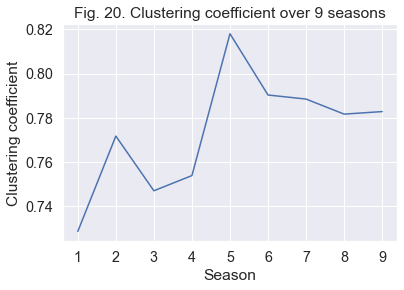

In [83]:
clustering_coef = []
for season, network in season_networks.items():
    CC = nx.algorithms.cluster.average_clustering(network)
    clustering_coef.append(CC)
    print(f'The clustering coefficient for the network of season {season}: {CC}')

fig_count += 1
sns.lineplot(list(range(len(clustering_coef))), clustering_coef)
plt.title(f"Fig. {fig_count}. Clustering coefficient over 9 seasons")
plt.xlabel("Season")
plt.ylabel("Clustering coefficient")
plt.xticks(list(range(len(clustering_coef))), list(range(1,10)))
plt.show()

### Exponent for each seasons scene networks

When analysing each seasons network degree exponent, found in the graph below, it is
clear that season one is an outlier. To that point it is important to note that
season one is an outlier in itself, as it has just six episodes, whereas the
remaining seasons have somewhere in the neighborhood of 20 episodes.
**The difference in exponent between season two and the remaining seasons however,
is a more interesting topic of discussion.** The exponent of the network for season
two is 2.97 and the highest exponent for the rest of the shows lifespan being
2.07 remarkably lower. This shows that **the network for dialogue in season two
just on the cusp of a random network and that the network for the following
seasons is more clearly within the scale-free regime**[14]. This shows an interesting
phenomenon in the show; that especially in the outlier season one, but also **in
season two the characters, who interact with each other, is significantly more
random than the remaining seasons.** One explanation for this could be that,
during the initial seasons of the show, the writers did not know exactly where
they wanted to take each different character and their interactions, and that
this resulted in the higher randomness than the following seasons. This could tie
in with the fact that the writers also did not know which characters the audience
liked the most, and by extension which characters the writers should spend more
time on developing.

exponent for degree in season 1: 4.570989945515009
exponent for degree in season 2: 2.992080112057276
exponent for degree in season 3: 1.7421672088870757
exponent for degree in season 4: 1.9269699200588342
exponent for degree in season 5: 2.026745077250994
exponent for degree in season 6: 2.069516625293787
exponent for degree in season 7: 1.8470570801038657
exponent for degree in season 8: 1.9051279556767282
exponent for degree in season 9: 2.0756289884983237


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


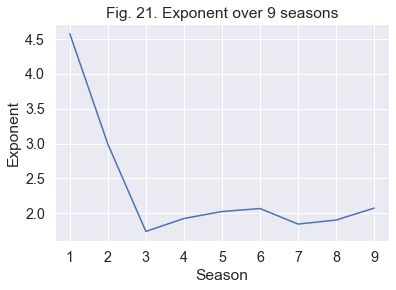

In [84]:
exponent = []
for season, network in season_networks.items():
    degree = [v[1] for v in network.degree]
    fit = powerlaw.Fit(degree, discrete=True)
    exponent.append(fit.power_law.alpha)
    print(f"exponent for degree in season {season}:", fit.power_law.alpha)

fig_count += 1
sns.lineplot(list(range(len(exponent))), exponent)
plt.title(f"Fig. {fig_count}. Exponent over 9 seasons")
plt.xlabel("Season")
plt.ylabel("Exponent")
plt.xticks(list(range(len(exponent))), list(range(1,10)))
plt.show()

### Visualizing connections between main characters over time

The following section dives into the interactions between the character Dwight
and a few of the other main characters. It is important to note that **the graph
displays the average interactions during an episode for a given season.** This ensures
that even though season one has fewer episodes, it will still be comparable.
With that said it is interesting to see that **Michael is by far the character
Dwight interacts with the most throughout the first six seasons.** During season
seven, leading up to Michaels departure from the show in season eight an nine,
**Jim became the character Dwight interacted with the most and from season eight rivaling Michaels
previous average interactions.** Another interesting point to draw from
the graph is Dwights increased interactions between season four and five.
**With the exception of Ryan, Dwights interaction count was even or up across the board
between the two seasons** even when accounting for the increased number of episodes in
season five compared to four. This could indicate the writers wanting to increase his
role in the show or shift his role into interacting with a higher varity of other main
characters.

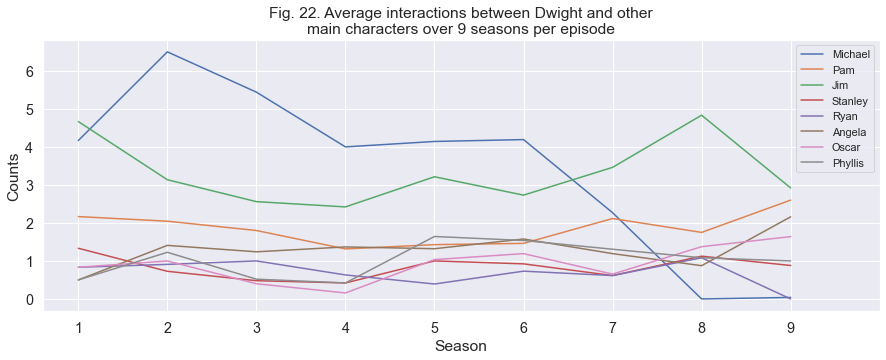

In [85]:
episodes_per_season = [6, 22, 25, 19, 28, 26, 26, 24, 25]
interactions_with = defaultdict(list)
MAIN_CHARACTER = 'Dwight'
OTHER_CHARACTERS = ['Michael', 'Pam', 'Jim', 'Stanley', 'Ryan', 'Angela', 'Oscar', 'Phyllis']
for season, network in season_networks.items():
    for other in OTHER_CHARACTERS:
        interactions_with[other].append(network.get_edge_data(MAIN_CHARACTER, other,
                                                             default={'weight' : 0})['weight'] / episodes_per_season[season - 1])

x = list(range(9))
plt.figure(figsize = (15, 5))
for name, interactions in interactions_with.items():
    sns.lineplot(x, interactions, label=name)
    
fig_count += 1
plt.title(f"Fig. {fig_count}. Average interactions between {MAIN_CHARACTER} and other\nmain characters over 9 seasons per episode")
plt.xlabel("Season")
plt.ylabel("Counts")
ticks = list(range(1,11))
ticks[-1] = ""
plt.xticks(list(range(10)), ticks)
plt.legend(fontsize=11, loc='best')
plt.show()

# Discussion

Originally we intended to episode ratings from IMDB and we still think trying to find a correlation between rating and appearance of certain characters and/or conversation topics is a interesting and fun idea. This type of analysis would be a natural extension of our current dialogue analysis. Questions that would be answered with such analysis could be. Which episodes are rated highest/lowest on IMDB? What are the dialogue topics of said episodes and which characters are responsible for bringing up those topics? Is there a general correlation between certain topics and high/low rating? Is there a general correlation between certain characters having a high/low number of lines in an episode and its IMDB rating?

We showed that network of The Office characters does not contain well defined communities regardless of whether we analyse graph based on Dunderpedia pages or a weighted graph based on dialogues. Most of the relationships is centered around main characters and there is no or little interaction between side- or supporting characters.

To calculate the sentiments of dialogues we initially used both the LabMT dictionary-based approach and the rule-based approach using the VADER word list. However, we quickly leaned that LabMT doesn't work well with our dataset, since we have very short sentences after removing stop words and hereby lose part of the context of the conversation. The rule-based VADER method tries to take the context of a sentence into account, ie. the overall sentiment of a sentence might be intensified or decreased based on how one word is used in combination with others. Hence, the rule-based approach is a stronger tool.  

As for the LDA, we saw that The Office dialogues are not the best use case for this method. They contain a huge number of topics that are not easily specifiable. However, we were still able to make use of the resulting distributions to describe the characters and show similarities between them in yet another way.

Namespace turned out to be quite a large issue for this analysis. The wiki-pages and the dialogues had in most cases different names for characters, changing if they are called by their first or first and last name etc. This made analysis spanning multiple datasets impossible. That is the reason why analysis of the wiki-page network is seperated from the analysis of dialogue.

Even within one domain itself we had issues. On some of the character wiki-pages there were mentions of other characters in the biography that did not include a link, these mentions were in the form of just the first name as opposed to the usual first and last name. The dialogue dataset had similar issues, sometimes the speaker would be mentioned by first name and sometimes by first and last name. This obviously made the analysis more troublesome and limited the scope to one dataset at a time, but we made our best attempt to combat these namespace issues whenever possible.

# Contribution

|  	| Maja 	| Kasia 	| Malthe 	|
|---	|---	|---	|---	|
| Data preparation 	| 33% 	| 33% 	| 33% 	|
| Introduction 	| 100% 	|  	|  	|
| Community detection 	|  	| 100% 	|  	|
| Topic modelling 	|  	| 100% 	|  	|
| Sentiment analysis 	| 100% 	|  	|  	|
| Temporal patterns 	|  	|  	| 100% 	|
| Discussion 	|  	|  	| 100% 	|
| Website preparation 	| 33% 	| 33% 	| 33% 	|

# References

[1] Wikipedia, "Modularity (networks)", https://en.wikipedia.org/wiki/Modularity_(networks). [Accessed: 25.11.2021].  

[2] U. Brandes, D. Delling, M. Gaertler et al. (February 2008). "On Modularity Clustering". IEEE Transactions on Knowledge and Data Engineering. 20 (2): 172–188. https://dx.doi.org/10.1109/TKDE.2007.190689.  

[3] Newman, M. E. J. (2006). "Modularity and community structure in networks". Proceedings of the National Academy of Sciences of the United States of America. 103 (23): 8577–8696. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1482622/.  

[4] A. Clauset, M. E. J. Newman, C. Moore, (2004), "Finding community structure in very large networks", DOI: 10.1103/PhysRevE.70.066111, https://arxiv.org/abs/cond-mat/0408187.  

[5] F. Pares, D. Garcia-Gasulla, A. Vilalta et al. (2017), "Fluid Communities: A Competitive, Scalable and Diverse Community Detection Algorithm", https://arxiv.org/abs/1703.09307v3.  

[6] M. E. J. Newman, "Modularity and community structure in networks", Proceedings of the National Academy of Sciences Jun 2006, 103 (23) 8577-8582; DOI: 10.1073/pnas.0601602103, https://www.pnas.org/content/103/23/8577.  

[7] M. A. Serranoa, M. Boguñáb, A. Vespignani (2009), "Extracting the multiscale backbone of complex weighted networks", https://www.pnas.org/content/pnas/106/16/6483.full.pdf.  

[8] python-backbone-network - Python implementation of method described in [7], https://github.com/aekpalakorn/python-backbone-network, [Accessed: 02.12.2021].

[9] Robertson, S. (2004). "Understanding inverse document frequency: On theoretical arguments for IDF". Journal of Documentation 60 (5): 503–520, http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.7340&rep=rep1&type=pdf.  

[10] *Understanding the use of logarithms in the TF-IDF logarithm*, https://stats.stackexchange.com/questions/161640/understanding-the-use-of-logarithms-in-the-tf-idf-logarithm, [Accessed 30.10.2021].  

[11] D. M. Blei, J. D. Lafferty (2009), "Topic models", http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf.

[12] Dodds P. S., Harris K. D., Kloumann I. M., Bliss C. A., Danforth C. M. (2011). "Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter". PLoS ONE 6 (12): e26752. https://doi.org/10.1371/journal.pone.0026752.

[13] Hutto, C., & Gilbert, E. (2014). "VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text". Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216-225. https://ojs.aaai.org/index.php/ICWSM/article/view/14550

[14] Barabási, Albert-László (2016) "Network Science" Chapter 4; section 7. http://networksciencebook.com/chapter/4#degree-exponent.  

[15] "Hellinger distance", https://en.wikipedia.org/wiki/Hellinger_distance, [Accessed: 04.12.2021].  

[16] Liu XF, Liu YL, Lu XH, Wang QX, Wang TX (2016) The Anatomy of the Global Football Player Transfer Network: Club Functionalities versus Network Properties. PLOS ONE 11(6): e0156504. https://doi.org/10.1371/journal.pone.0156504.